In [ ]:
Simport numpy as np
import pandas as pd

df = pd.read_csv('/content/facial_angle_analysis_results.csv')
df.head()

image_path             image_name  \
0  /content/facial_palsy_dataset/temp_extract_1/E...         10_M_eye59.jpg   
1  /content/facial_palsy_dataset/temp_extract_1/E...  rotated_9_M_eye52.jpg   
2  /content/facial_palsy_dataset/temp_extract_1/E...         28_M_eye10.jpg   
3  /content/facial_palsy_dataset/temp_extract_1/E...        22_M_eye109.jpg   
4  /content/facial_palsy_dataset/temp_extract_1/E...       rotated_3156.jpg   

  category  severity  class_label      class_name  eyebrow_angle  eye_angle  \
0      Eye  Moderate            2  Palsy_Moderate       0.000000   0.000000   
1      Eye  Moderate            2  Palsy_Moderate     -22.479434 -24.443955   
2      Eye  Moderate            2  Palsy_Moderate       2.489553  -3.366461   
3      Eye  Moderate            2  Palsy_Moderate      -6.581945   0.000000   
4      Eye  Moderate            2  Palsy_Moderate     -27.897271 -24.623565   

   mouth_angle   status  
0     3.179830  success  
1   -28.072487  success  
2    10.304846  success  
3    -4.763642  success  
4   -25.201124  success

In [ ]:
df['category'].value_counts()

category
Eyebrow    7592
Eye        5099
Mouth      4698
Normal     1000
Name: count, dtype: int64

In [ ]:
import cv2
import numpy as np
import dlib
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import os
import urllib.request
import bz2

# ============================================================================
# MODEL SETUP
# ============================================================================

print("📥 Setting up face detection models...")

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Face detection models loaded successfully\n")

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))
    raise ValueError("No face detected")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = detect_face_dnn(image)
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """Create 6 clusters: left/right for eyebrows, eyes, mouth"""
    clusters = {
        'left_eyebrow': [], 'right_eyebrow': [],
        'left_eye': [], 'right_eye': [],
        'left_mouth': [], 'right_mouth': []
    }

    for i, point in enumerate(landmarks):
        x, y = point
        if 17 <= i <= 26:  # Eyebrow points
            if x < midline_x: clusters['left_eyebrow'].append(point)
            else: clusters['right_eyebrow'].append(point)
        elif 36 <= i <= 47:  # Eye points
            if x < midline_x: clusters['left_eye'].append(point)
            else: clusters['right_eye'].append(point)
        elif 48 <= i <= 67:  # Mouth points
            if x < midline_x: clusters['left_mouth'].append(point)
            else: clusters['right_mouth'].append(point)

    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])
    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """Extract only 3 angle features"""
    features = {}

    # Eyebrow angle
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features, prediction, probabilities, class_names):
    """Visualize the analysis with prediction results"""
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Find midline for visualization
    midline_x = find_midline(landmarks)

    # Draw midline
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)

    # Draw landmarks
    for point in landmarks:
        cv2.circle(vis_img, tuple(point.astype(int)), 2, (200, 200, 200), -1)

    # Draw angle lines
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 0, 0), 2, cv2.LINE_AA)

    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (0, 255, 0), 2, cv2.LINE_AA)

    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (0, 0, 255), 2, cv2.LINE_AA)

    # Add prediction text
    # Ensure prediction index is within bounds
    if 0 <= prediction < len(class_names):
        pred_class = class_names[prediction]
        confidence = probabilities[prediction]
    else:
        pred_class = "Unknown"
        confidence = 0.0 # Or handle as appropriate

    # Create info text
    info_text = [
        f"Prediction: {pred_class}",
        f"Confidence: {confidence:.2%}",
        f"Eyebrow: {features['eyebrow_angle']:.1f}°",
        f"Eye: {features['eye_angle']:.1f}°",
        f"Mouth: {features['mouth_angle']:.1f}°"
    ]

    # Add text to image
    y_offset = 30
    for text in info_text:
        cv2.putText(vis_img, text, (10, y_offset),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        y_offset += 25

    return vis_img

# ============================================================================
# LOAD TRAINED MODEL
# ============================================================================

def load_trained_model():
    """Load the trained Random Forest model and its info"""
    print("📊 Loading trained model...")

    model_path = "/content/facial_palsy_rf_model_mouth_with_celeba.pkl"
    # Corrected model info path to include CelebA
    info_path = "/content/model_info_with_celeba.pkl"

    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)

        with open(info_path, 'rb') as f:
            model_info = pickle.load(f)

        print("✅ Model loaded successfully!")
        print(f"   Model type: Random Forest")
        print(f"   Classes: {model_info['class_names']}")
        print(f"   Features: {model_info['feature_names']}")
        print(f"   Test accuracy: {model_info.get('test_accuracy', 'N/A')}")

        return model, model_info

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

# ============================================================================
# PROCESS MOUTH IMAGES AND MAKE PREDICTIONS
# ============================================================================

def process_mouth_images_and_predict():
    """Process mouth directory images and apply the trained model"""

    print("\n" + "="*80)
    print("PROCESSING MOUTH IMAGES WITH TRAINED MODEL")
    print("="*80)

    # Load the trained model
    model, model_info = load_trained_model()
    if model is None:
        return

    class_names = model_info['class_names']
    feature_names = model_info['feature_names']

    # Define mouth directory path
    mouth_dir = Path("/content/mouth_analysis")  # Update this path if needed

    # Find all mouth images
    mouth_images = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        mouth_images.extend(mouth_dir.rglob(ext))

    print(f"\n🔍 Found {len(mouth_images)} mouth images")

    if not mouth_images:
        print("❌ No images found in the mouth directory")
        return

    # Process first 10 images (or all if less than 10)
    sample_images = mouth_images[:10]
    results = []

    for i, image_path in enumerate(sample_images):
        print(f"\n{'='*60}")
        print(f"PROCESSING IMAGE {i+1}/{len(sample_images)}: {image_path.name}")
        print(f"{'='*60}")

        try:
            # Load image
            image = cv2.imread(str(image_path))
            if image is None:
                print(f"❌ Could not load image: {image_path}")
                continue

            # Extract features
            print("📐 Extracting facial landmarks and features...")
            landmarks, face = get_landmarks(image)
            midline_x = find_midline(landmarks)
            clusters = create_clusters(landmarks, midline_x)
            features = extract_angle_features(clusters, landmarks)

            # Display extracted features
            print(f"\n📊 Extracted Angle Features:")
            print(f"  Eyebrow angle: {features['eyebrow_angle']:.2f}°")
            print(f"  Eye angle:     {features['eye_angle']:.2f}°")
            print(f"  Mouth angle:   {features['mouth_angle']:.2f}°")

            # Prepare features for prediction
            feature_array = np.array([[
                features['eyebrow_angle'],
                features['eye_angle'],
                features['mouth_angle']
            ]])

            # Make prediction
            print("\n🤖 Making prediction with trained model...")
            prediction = model.predict(feature_array)[0]
            probabilities = model.predict_proba(feature_array)[0]

            # Display results
            print(f"\n🎯 PREDICTION RESULTS:")
            # Ensure prediction index is valid before accessing class_names
            if 0 <= prediction < len(class_names):
                print(f"  Predicted class: {class_names[prediction]}")
                print(f"  Confidence: {probabilities[prediction]:.2%}")
            else:
                 print(f"  Predicted class: Unknown (Index out of range: {prediction})")
                 print(f"  Confidence: N/A")


            print(f"\n📈 ALL CLASS PROBABILITIES:")
            # Ensure class_names and probabilities have compatible lengths
            if len(class_names) == len(probabilities):
                for class_idx, prob in enumerate(probabilities):
                    print(f"  {class_names[class_idx]}: {prob:.2%}")
            else:
                print("  Cannot display probabilities: Mismatch between class names and probabilities length.")
                print(f"  Class names length: {len(class_names)}")
                print(f"  Probabilities length: {len(probabilities)}")


            # Create visualization
            vis_img = visualize_analysis(image, landmarks, clusters, features,
                                       prediction, probabilities, class_names)

            # Display results
            plt.figure(figsize=(15, 5))

            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Original: {image_path.name}')
            plt.axis('off')

            # Analysis with prediction
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
            plt.title('Analysis with Prediction')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Store results
            # Ensure prediction index is valid before storing
            if 0 <= prediction < len(class_names):
                result = {
                    'image_path': str(image_path),
                    'image_name': image_path.name,
                    'eyebrow_angle': features['eyebrow_angle'],
                    'eye_angle': features['eye_angle'],
                    'mouth_angle': features['mouth_angle'],
                    'predicted_class': prediction,
                    'predicted_class_name': class_names[prediction],
                    'confidence': probabilities[prediction],
                    'all_probabilities': probabilities.tolist()
                }
                results.append(result)
            else:
                 print(f"Skipping result storage for {image_path.name} due to invalid prediction index.")


            # Interpretation
            print(f"\n💡 INTERPRETATION:")
            max_angle = max(abs(features['eyebrow_angle']),
                           abs(features['eye_angle']),
                           abs(features['mouth_angle']))

            if max_angle <= 2:
                severity_note = "Normal facial symmetry"
            elif max_angle <= 5:
                severity_note = "Mild asymmetry"
            elif max_angle <= 10:
                severity_note = "Moderate asymmetry"
            else:
                severity_note = "Severe asymmetry"

            print(f"  • Maximum angle deviation: {max_angle:.2f}°")
            print(f"  • {severity_note}")

        except Exception as e:
            print(f"❌ Error processing {image_path.name}: {e}")
            continue

    # Save results to CSV
    if results:
        results_df = pd.DataFrame(results)
        results_csv_path = "/content/mouth_image_predictions.csv"
        results_df.to_csv(results_csv_path, index=False)
        print(f"\n💾 Results saved to: {results_csv_path}")

        # Print summary
        print(f"\n📊 PREDICTION SUMMARY:")
        prediction_counts = results_df['predicted_class_name'].value_counts()
        for class_name, count in prediction_counts.items():
            print(f"  {class_name}: {count} images")

    return results

# ============================================================================
# RUN THE PROCESSING
# ============================================================================

if __name__ == "__main__":
    # Process mouth images and make predictions
    results = process_mouth_images_and_predict()

    if results:
        print(f"\n✅ Successfully processed {len(results)} images!")
        print(f"📁 Results saved to: /content/mouth_image_predictions.csv")
    else:
        print(f"\n❌ No images were successfully processed.")

📥 Setting up face detection models...
✅ Face detection models loaded successfully


PROCESSING MOUTH IMAGES WITH TRAINED MODEL
📊 Loading trained model...
❌ Error loading model: [Errno 2] No such file or directory: '/content/facial_palsy_rf_model_mouth_with_celeba.pkl'

❌ No images were successfully processed.


🎯 STARTING RANDOM FOREST TRAINING WITH EQUAL CLASS DISTRIBUTION
🎯 Target: 2000 instances per class
📊 Loading data from CSV...
Original dataset shape: (18389, 10)
Columns: ['image_path', 'image_name', 'category', 'severity', 'class_label', 'class_name', 'eyebrow_angle', 'eye_angle', 'mouth_angle', 'status']

📁 After filtering Mouth category: 4698 rows
📋 Unique severities in Mouth data:
severity
Moderate severe    2622
Mild                933
Moderate            670
Severe              473
Name: count, dtype: int64
📋 Unique class_labels in Mouth data:
class_label
1     933
2     670
3    3095
Name: count, dtype: int64
🔍 Unique class labels before merging: [np.int64(1), np.int64(2), np.int64(3)]

✅ Successful feature extraction rows: 4698

🌟 Adding CelebA normal faces as class 0...
📥 Downloading CelebA dataset for normal faces...


100%|██████████| 1.33G/1.33G [00:13<00:00, 109MB/s]

Extracting files...


✅ CelebA downloaded to: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2
📁 Found 202599 CelebA images
🔧 Processing 2000 CelebA images...
📥 Setting up face detection models for CelebA...


Processing CelebA: 100%|██████████| 2000/2000 [02:15<00:00, 14.77it/s]


✅ Successfully processed 1992/2000 CelebA images
✅ Added 1992 CelebA normal faces
🎯 Available classes after processing: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

🎯 Initial class distribution:
  Class 0 (Normal): 1992 samples
  Class 1 (Mild): 933 samples
  Class 2 (Moderate): 670 samples
  Class 3 (Severe): 3095 samples
🎯 Training with classes: ['Normal', 'Mild', 'Moderate', 'Severe']
🎯 Class labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

⚖️ Balancing dataset with exactly 2000 instances per class...
  Class 0 (Normal): 1992 → 2000 (upsampled)
  Class 1 (Mild): 933 → 2000 (upsampled)
  Class 2 (Moderate): 670 → 2000 (upsampled)
  Class 3 (Severe): 3095 → 2000 (downsampled)

📊 Final balanced dataset: 8000 samples
Class distribution after balancing:
  Class 0 (Normal): 2000 samples
  Class 1 (Mild): 2000 samples
  Class 2 (Moderate): 2000 samples
  Class 3 (Severe): 2000 samples
✅ SUCCESS: All classes have exactly 2000 instances

📐 Feature matrix shape: (8000, 3

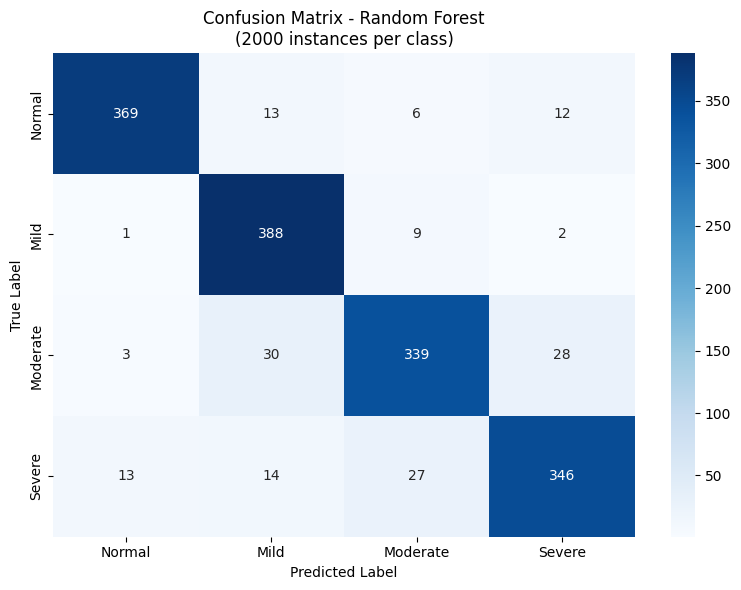


💪 Feature Importance:
  Eyebrow Angle: 0.3296
  Eye Angle: 0.2351
  Mouth Angle: 0.4353


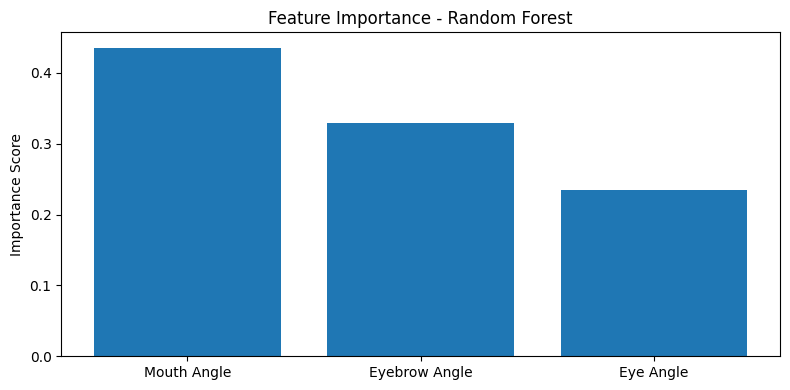


💾 Model saved to: /content/facial_palsy_rf_model_equal_2000perclass.pkl
💾 Model info saved to: /content/model_info_equal_2000perclass.pkl

📊 Feature Distribution by Class:


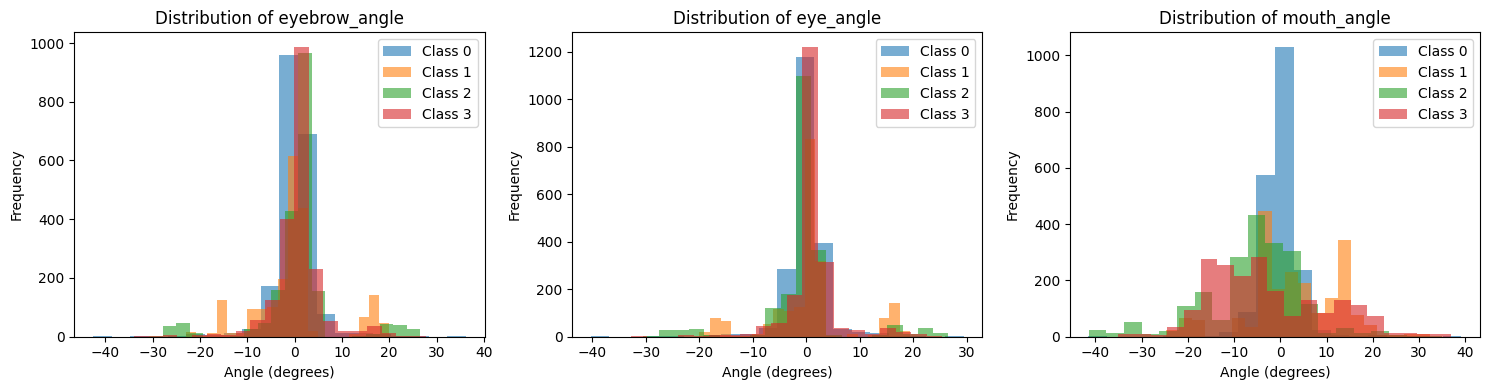


✅ TRAINING COMPLETE!
   • Model: Random Forest
   • Classes: ['Normal', 'Mild', 'Moderate', 'Severe']
   • Class labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
   • Samples per class: 2000
   • Total samples: 8000
   • Test Accuracy: 0.9012
   • Features used: ['eyebrow_angle', 'eye_angle', 'mouth_angle']
   • Model saved as: /content/facial_palsy_rf_model_equal_2000perclass.pkl


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from pathlib import Path
import cv2
import dlib
import os
import urllib.request
import bz2
import shutil
from tqdm import tqdm

# ============================================================================
# FACE DETECTION SETUP (for CelebA processing)
# ============================================================================

def setup_face_detection():
    """Setup face detection models for CelebA processing"""
    print("📥 Setting up face detection models for CelebA...")

    FACE_PROTO = "deploy.prototxt"
    FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

    if not os.path.exists(FACE_PROTO):
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
            FACE_PROTO
        )

    if not os.path.exists(FACE_MODEL):
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemovelel",
            FACE_MODEL
        )

    LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
    if not os.path.exists(LANDMARK_MODEL):
        urllib.request.urlretrieve(
            "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
            "shape_predictor_68_face_landmarks.dat.bz2"
        )
        with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
            with open(LANDMARK_MODEL, 'wb') as out:
                out.write(f.read())

    face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
    landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)

    return face_net, landmark_predictor

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS (for CelebA)
# ============================================================================

def detect_face_dnn(image, face_net, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))
    raise ValueError("No face detected")

def get_landmarks(image, face_net, landmark_predictor):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = detect_face_dnn(image, face_net)
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """Create 6 clusters: left/right for eyebrows, eyes, mouth"""
    clusters = {
        'left_eyebrow': [], 'right_eyebrow': [],
        'left_eye': [], 'right_eye': [],
        'left_mouth': [], 'right_mouth': []
    }

    for i, point in enumerate(landmarks):
        x, y = point
        if 17 <= i <= 26:  # Eyebrow points
            if x < midline_x: clusters['left_eyebrow'].append(point)
            else: clusters['right_eyebrow'].append(point)
        elif 36 <= i <= 47:  # Eye points
            if x < midline_x: clusters['left_eye'].append(point)
            else: clusters['right_eye'].append(point)
        elif 48 <= i <= 67:  # Mouth points
            if x < midline_x: clusters['left_mouth'].append(point)
            else: clusters['right_mouth'].append(point)

    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])
    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """Extract only 3 angle features"""
    features = {}

    # Eyebrow angle
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

# ============================================================================
# CELEBA DATASET DOWNLOAD AND PROCESSING
# ============================================================================

def download_and_process_celeba(num_samples=2000):
    """Download CelebA dataset and extract features for normal faces"""

    print("📥 Downloading CelebA dataset for normal faces...")

    try:
        # Download CelebA dataset
        celeba_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
        print(f"✅ CelebA downloaded to: {celeba_path}")

        # Find the image directory
        celeba_img_dir = Path(celeba_path) / "img_align_celeba" / "img_align_celeba"
        if not celeba_img_dir.exists():
            celeba_img_dir = Path(celeba_path) / "img_align_celeba"

        # Get all CelebA images
        all_celeba_images = list(celeba_img_dir.glob("*.jpg"))
        print(f"📁 Found {len(all_celeba_images)} CelebA images")

        # Take a subset for processing
        sample_images = all_celeba_images[:num_samples]
        print(f"🔧 Processing {len(sample_images)} CelebA images...")

        # Setup face detection
        face_net, landmark_predictor = setup_face_detection()

        # Process CelebA images
        celeba_data = []
        successful_count = 0

        for i, img_path in enumerate(tqdm(sample_images, desc="Processing CelebA")):
            try:
                # Load image
                image = cv2.imread(str(img_path))
                if image is None:
                    continue

                # Extract features
                landmarks, face = get_landmarks(image, face_net, landmark_predictor)
                midline_x = find_midline(landmarks)
                clusters = create_clusters(landmarks, midline_x)
                features = extract_angle_features(clusters, landmarks)

                # Add to dataset
                celeba_data.append({
                    'image_path': str(img_path),
                    'image_name': img_path.name,
                    'category': 'Normal',
                    'severity': 'Normal',
                    'class_label': 0,
                    'class_name': 'Normal',
                    'eyebrow_angle': features['eyebrow_angle'],
                    'eye_angle': features['eye_angle'],
                    'mouth_angle': features['mouth_angle'],
                    'status': 'success'
                })
                successful_count += 1

            except Exception as e:
                # Skip images that fail processing
                continue

        print(f"✅ Successfully processed {successful_count}/{len(sample_images)} CelebA images")
        return pd.DataFrame(celeba_data)

    except Exception as e:
        print(f"❌ Error downloading/processing CelebA: {e}")
        return pd.DataFrame()

# ============================================================================
# LOAD AND PREPARE DATA FROM CSV (UPDATED WITH CELEBA)
# ============================================================================

def load_and_prepare_data(csv_path, target_samples_per_class=2000):
    """Load CSV data and prepare for training with equal instances for all 4 classes"""

    print("📊 Loading data from CSV...")
    df = pd.read_csv(csv_path)

    print(f"Original dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Filter only Mouth category
    df_mouth = df[df['category'] == 'Mouth'].copy()
    print(f"\n📁 After filtering Mouth category: {df_mouth.shape[0]} rows")

    # Check unique severities and class labels BEFORE merging
    print(f"📋 Unique severities in Mouth data:")
    print(df_mouth['severity'].value_counts())
    print(f"📋 Unique class_labels in Mouth data:")
    print(df_mouth['class_label'].value_counts().sort_index())

    # Merge Moderate severe and Severe into Severe (class 3)
    unique_classes_before = df_mouth['class_label'].unique()
    print(f"🔍 Unique class labels before merging: {sorted(unique_classes_before)}")

    # Map all severe classes to class 3
    severe_classes = [3, 4, 5]  # Include possible severe class labels
    for severe_class in severe_classes:
        if severe_class in df_mouth['class_label'].values:
            df_mouth['class_label'] = df_mouth['class_label'].replace({severe_class: 3})

    # Filter only successful rows
    df_success = df_mouth[df_mouth['status'] == 'success'].copy()
    print(f"\n✅ Successful feature extraction rows: {df_success.shape[0]}")

    # Add CelebA normal faces to ensure we have class 0
    print("\n🌟 Adding CelebA normal faces as class 0...")
    celeba_df = download_and_process_celeba(num_samples=target_samples_per_class)
    if not celeba_df.empty:
        df_success = pd.concat([df_success, celeba_df], ignore_index=True)
        print(f"✅ Added {len(celeba_df)} CelebA normal faces")
    else:
        print("❌ Could not add CelebA data")

    # Get the actual available classes after processing
    available_classes = sorted(df_success['class_label'].unique())
    print(f"🎯 Available classes after processing: {available_classes}")

    # Create dynamic class names mapping
    class_name_mapping = {
        0: 'Normal',
        1: 'Mild',
        2: 'Moderate',
        3: 'Severe'
    }

    # Only include classes that actually exist in our data
    actual_class_names = [class_name_mapping[cls] for cls in available_classes]

    # Update class names in dataframe
    df_success['class_name'] = df_success['class_label'].map(class_name_mapping)

    # Check initial class distribution
    print(f"\n🎯 Initial class distribution:")
    class_distribution = df_success['class_label'].value_counts().sort_index()
    for class_label, count in class_distribution.items():
        class_name = class_name_mapping[class_label]
        print(f"  Class {class_label} ({class_name}): {count} samples")

    return df_success, actual_class_names, available_classes

def balance_dataset_equal(df, target_samples_per_class=2000):
    """Balance the dataset with exactly equal instances for all classes"""

    print(f"\n⚖️ Balancing dataset with exactly {target_samples_per_class} instances per class...")

    # Get unique classes from the actual data
    unique_classes = sorted(df['class_label'].unique())

    balanced_dfs = []

    for class_label in unique_classes:
        class_df = df[df['class_label'] == class_label]
        current_count = len(class_df)
        class_name = class_df['class_name'].iloc[0]

        print(f"  Class {class_label} ({class_name}): {current_count} → ", end="")

        if current_count < target_samples_per_class:
            # Upsample minority class
            class_df_upsampled = resample(class_df,
                                        replace=True,
                                        n_samples=target_samples_per_class,
                                        random_state=42)
            balanced_dfs.append(class_df_upsampled)
            print(f"{target_samples_per_class} (upsampled)")
        elif current_count > target_samples_per_class:
            # Downsample majority class
            class_df_downsampled = resample(class_df,
                                          replace=False,
                                          n_samples=target_samples_per_class,
                                          random_state=42)
            balanced_dfs.append(class_df_downsampled)
            print(f"{target_samples_per_class} (downsampled)")
        else:
            # Already has exactly target_samples_per_class
            balanced_dfs.append(class_df)
            print(f"{target_samples_per_class} (perfect)")

    # Combine balanced datasets
    df_balanced = pd.concat(balanced_dfs, ignore_index=True)

    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n📊 Final balanced dataset: {df_balanced.shape[0]} samples")
    print("Class distribution after balancing:")
    final_dist = df_balanced['class_label'].value_counts().sort_index()
    for class_label, count in final_dist.items():
        class_name = df_balanced[df_balanced['class_label'] == class_label]['class_name'].iloc[0]
        print(f"  Class {class_label} ({class_name}): {count} samples")

    # Verify equal distribution
    unique_counts = final_dist.unique()
    if len(unique_counts) == 1:
        print(f"✅ SUCCESS: All classes have exactly {unique_counts[0]} instances")
    else:
        print(f"⚠️  WARNING: Classes have different counts: {unique_counts}")

    return df_balanced

# ============================================================================
# MODEL TRAINING (UPDATED)
# ============================================================================

def train_random_forest_from_csv(csv_path, samples_per_class=2000):
    """Main function to train Random Forest from CSV data with equal class distribution"""

    print("🎯 STARTING RANDOM FOREST TRAINING WITH EQUAL CLASS DISTRIBUTION")
    print("=" * 70)
    print(f"🎯 Target: {samples_per_class} instances per class")
    print("=" * 70)

    # Step 1: Load and prepare data
    df, CLASS_NAMES, available_classes = load_and_prepare_data(csv_path, target_samples_per_class=samples_per_class)

    if df.empty:
        print("❌ No data available for training!")
        return None, None, None

    print(f"🎯 Training with classes: {CLASS_NAMES}")
    print(f"🎯 Class labels: {available_classes}")

    # Step 2: Balance the dataset with exactly equal instances
    df_balanced = balance_dataset_equal(df, target_samples_per_class=samples_per_class)

    # Step 3: Prepare features and labels
    feature_columns = ['eyebrow_angle', 'eye_angle', 'mouth_angle']
    X = df_balanced[feature_columns].values
    y = df_balanced['class_label'].values

    print(f"\n📐 Feature matrix shape: {X.shape}")
    print(f"🎯 Label vector shape: {y.shape}")
    print(f"🔢 Unique labels in y: {np.unique(y)}")

    # Verify equal distribution in the final dataset
    unique, counts = np.unique(y, return_counts=True)
    print(f"🔍 Final class distribution verification:")
    for class_label, count in zip(unique, counts):
        print(f"  Class {class_label}: {count} samples")

    # Step 4: Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\n📊 Dataset split:")
    print(f"  Training set: {X_train.shape[0]} samples")
    print(f"  Test set: {X_test.shape[0]} samples")
    print(f"  Features: {X_train.shape[1]} ({', '.join(feature_columns)})")

    # Verify equal distribution in train/test splits
    print(f"\n🔍 Train set class distribution:")
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    for class_label, count in zip(train_unique, train_counts):
        print(f"  Class {class_label}: {count} samples")

    print(f"🔍 Test set class distribution:")
    test_unique, test_counts = np.unique(y_test, return_counts=True)
    for class_label, count in zip(test_unique, test_counts):
        print(f"  Class {class_label}: {count} samples")

    # Step 5: Train Random Forest
    print("\n🌲 Training Random Forest classifier...")
    rf_model = RandomForestClassifier(
        n_estimators=200,  # Increased for larger dataset
        max_depth=20,      # Increased for larger dataset
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1  # Use all available cores for faster training
    )

    rf_model.fit(X_train, y_train)

    # Step 6: Evaluate model
    print("\n📈 Model Evaluation:")

    # Training accuracy
    y_train_pred = rf_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"  Training Accuracy: {train_accuracy:.4f}")

    # Test accuracy
    y_pred = rf_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"  Test Accuracy: {test_accuracy:.4f}")

    # Detailed classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=CLASS_NAMES,
                               labels=available_classes,
                               digits=4))

    # Confusion matrix
    print(f"📊 Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=available_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix - Random Forest\n({samples_per_class} instances per class)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Feature importance
    print(f"\n💪 Feature Importance:")
    feature_names = ['Eyebrow Angle', 'Eye Angle', 'Mouth Angle']
    importances = rf_model.feature_importances_
    for name, importance in zip(feature_names, importances):
        print(f"  {name}: {importance:.4f}")

    # Plot feature importance
    plt.figure(figsize=(8, 4))
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.title('Feature Importance - Random Forest')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

    # Step 7: Save the model
    model_path = f"/content/facial_palsy_rf_model_equal_{samples_per_class}perclass.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(rf_model, f)

    print(f"\n💾 Model saved to: {model_path}")

    # Step 8: Save class names and feature information
    model_info = {
        'class_names': CLASS_NAMES,
        'available_classes': available_classes,
        'feature_names': feature_columns,
        'test_accuracy': test_accuracy,
        'model_type': 'RandomForest',
        'samples_per_class': samples_per_class,
        'total_samples': len(df_balanced)
    }

    info_path = f"/content/model_info_equal_{samples_per_class}perclass.pkl"
    with open(info_path, 'wb') as f:
        pickle.dump(model_info, f)

    print(f"💾 Model info saved to: {info_path}")

    # Step 9: Feature distribution analysis
    print(f"\n📊 Feature Distribution by Class:")
    plt.figure(figsize=(15, 4))

    for i, feature in enumerate(feature_columns, 1):
        plt.subplot(1, 3, i)
        for class_label in available_classes:
            class_data = df_balanced[df_balanced['class_label'] == class_label][feature]
            plt.hist(class_data, alpha=0.6, label=f'Class {class_label}', bins=20)
        plt.title(f'Distribution of {feature}')
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Final summary
    print(f"\n✅ TRAINING COMPLETE!")
    print(f"   • Model: Random Forest")
    print(f"   • Classes: {CLASS_NAMES}")
    print(f"   • Class labels: {available_classes}")
    print(f"   • Samples per class: {samples_per_class}")
    print(f"   • Total samples: {len(df_balanced)}")
    print(f"   • Test Accuracy: {test_accuracy:.4f}")
    print(f"   • Features used: {feature_columns}")
    print(f"   • Model saved as: {model_path}")

    return rf_model, CLASS_NAMES, available_classes

# ============================================================================
# RUN THE TRAINING
# ============================================================================

if __name__ == "__main__":
    # Replace with your actual CSV path
    csv_file_path = "/content/facial_angle_analysis_results.csv"

    # Train the model with 2000 instances per class
    samples_per_class = 2000
    trained_model, class_names, available_classes = train_random_forest_from_csv(
        csv_file_path,
        samples_per_class=samples_per_class
    )

📥 Setting up face detection models...
✅ Face detection models loaded successfully


PROCESSING MOUTH IMAGES WITH TRAINED MODEL (2000 IMAGES PER CLASS)
📦 Extracting mouth.zip...
✅ Extracted to: /content/mouth_analysis
📊 Loading trained model (2000 images per class)...
✅ Model loaded successfully!
   Model type: Random Forest
   Classes: ['Normal', 'Mild', 'Moderate', 'Severe']
   Features: ['eyebrow_angle', 'eye_angle', 'mouth_angle']
   Samples per class: 2000
   Total samples: 8000
   Test accuracy: 0.90125

📁 Found 1 subdirectories:
   • Mouth

🔍 Found 3901 total mouth images

PROCESSING IMAGE 1/3901: 6_Mi_mouth14.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: -6.34°
  Eye angle:     -3.37°
  Mouth angle:   9.87°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 99.94%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 0.00%
  Mild: 99.94%
  Mode

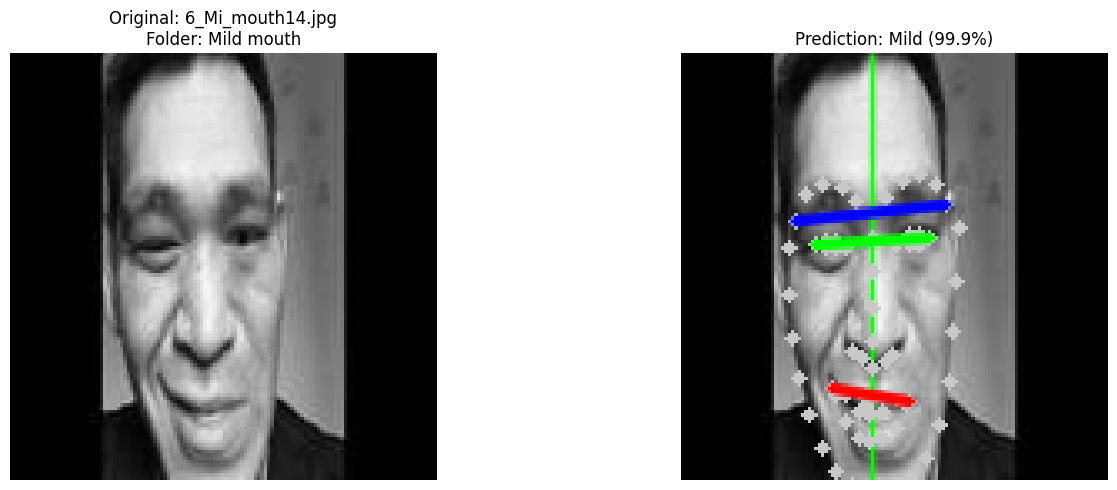


PROCESSING IMAGE 2/3901: cropped_6_Mi_mouth17.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: -1.12°
  Eye angle:     -1.51°
  Mouth angle:   13.50°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 81.07%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 1.93%
  Mild: 81.07%
  Moderate: 0.92%
  Severe: 16.08%


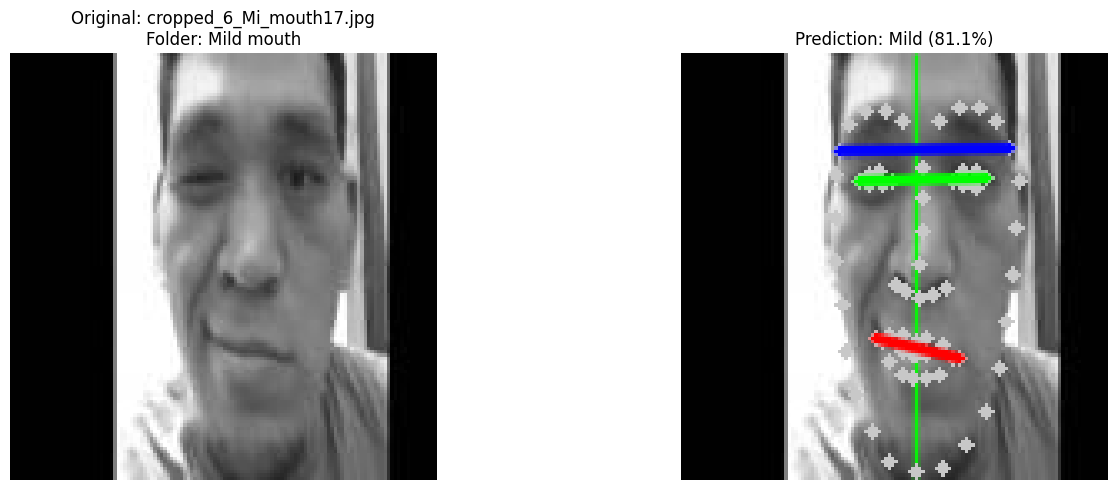


PROCESSING IMAGE 3/3901: 6_Mi_mouth10.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: -1.33°
  Eye angle:     0.00°
  Mouth angle:   19.98°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 86.16%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 1.65%
  Mild: 86.16%
  Moderate: 1.04%
  Severe: 11.16%



PROCESSING IMAGE 4/3901: 9_Mi_mouth11.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: 1.79°
  Eye angle:     0.00°
  Mouth angle:   0.00°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 85.01%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 4.82%
  Mild: 85.01%
  Moderate: 3.27%
  Severe: 6.90%



PROCESSING IMAGE 5/3901: rotated-10_9_Mi_mouth16.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: 18.43°
  Eye angle:     16.93°
  Mouth angle:   14.04°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 95.91%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 0.07%
  Mild: 95.91%
  Moderate: 2.95%
  Severe: 1.07%


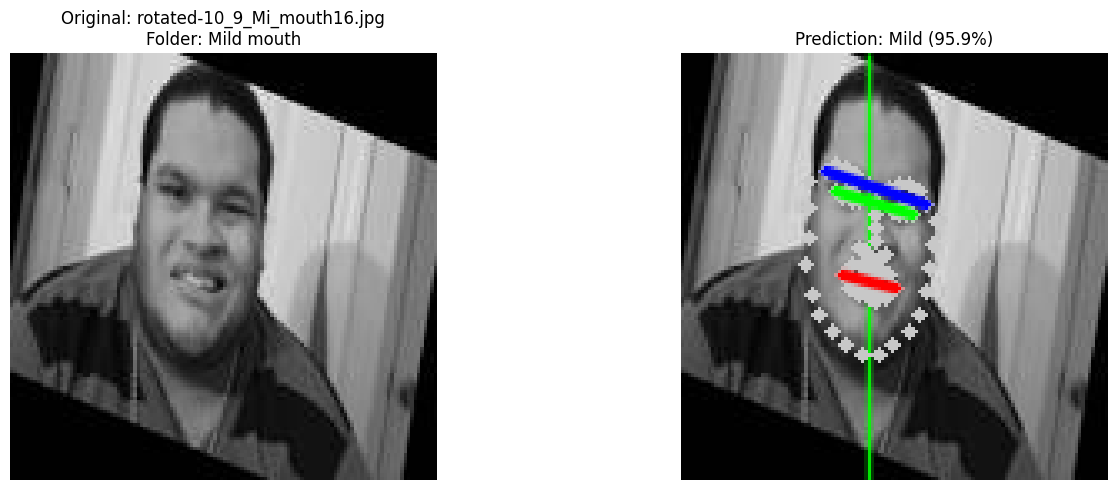


PROCESSING IMAGE 6/3901: noisy_20dB_14_Mi_mouth12.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: 0.00°
  Eye angle:     0.00°
  Mouth angle:   -4.09°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 74.19%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 6.60%
  Mild: 74.19%
  Moderate: 12.40%
  Severe: 6.81%


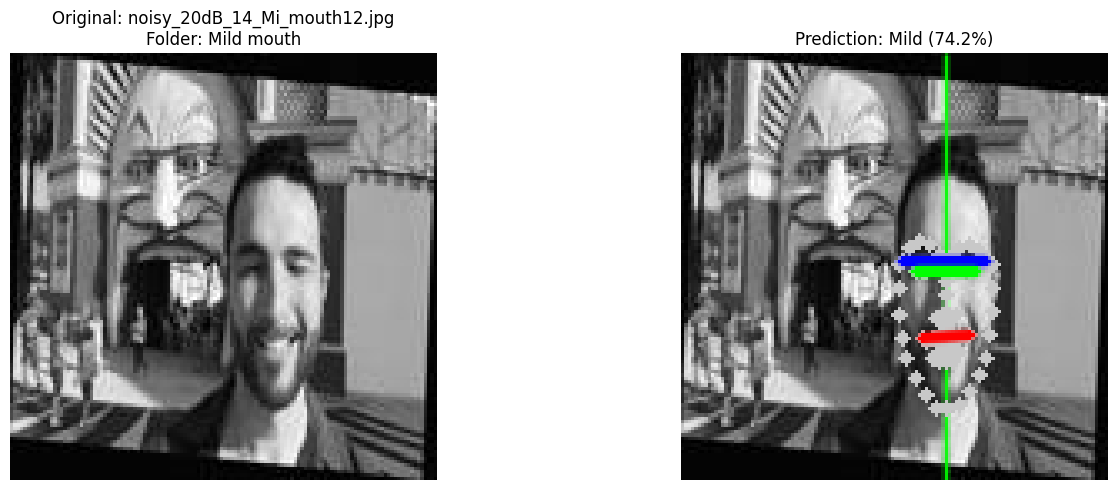


PROCESSING IMAGE 7/3901: rotated10_10_Mi_mouth14.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: 14.83°
  Eye angle:     16.26°
  Mouth angle:   17.53°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 97.24%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 0.17%
  Mild: 97.24%
  Moderate: 0.55%
  Severe: 2.04%



PROCESSING IMAGE 8/3901: noisy_20dB_10_Mi_mouth20.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: -3.27°
  Eye angle:     0.00°
  Mouth angle:   3.18°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 66.48%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 19.49%
  Mild: 66.48%
  Moderate: 1.87%
  Severe: 12.16%



PROCESSING IMAGE 9/3901: rotated-10_14_Mi_mouth2.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: -16.26°
  Eye angle:     -16.39°
  Mouth angle:   -24.78°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 94.87%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 0.00%
  Mild: 94.87%
  Moderate: 0.57%
  Severe: 4.56%


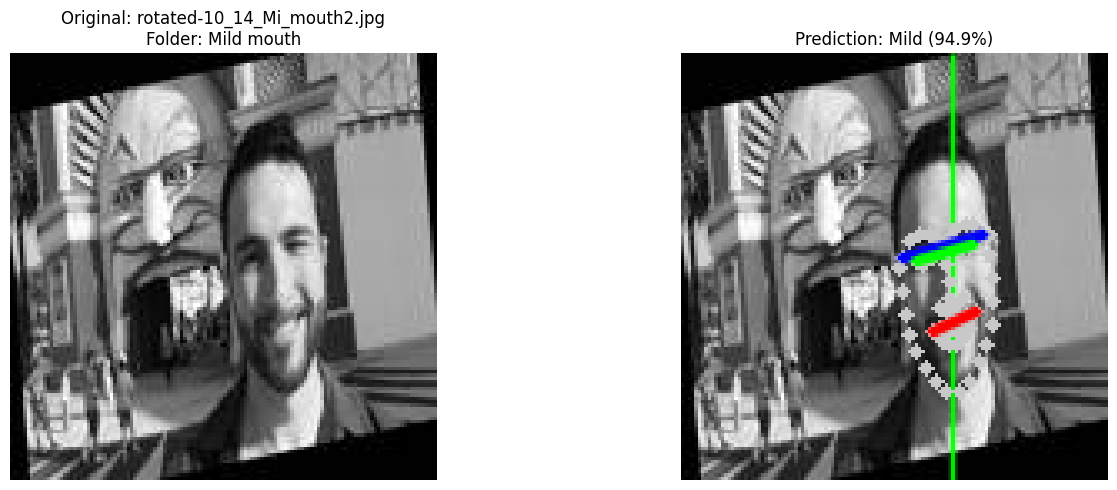


PROCESSING IMAGE 10/3901: noisy_20dB_9_Mi_mouth33.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: 1.79°
  Eye angle:     0.00°
  Mouth angle:   -3.18°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 93.73%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 1.33%
  Mild: 93.73%
  Moderate: 3.58%
  Severe: 1.35%


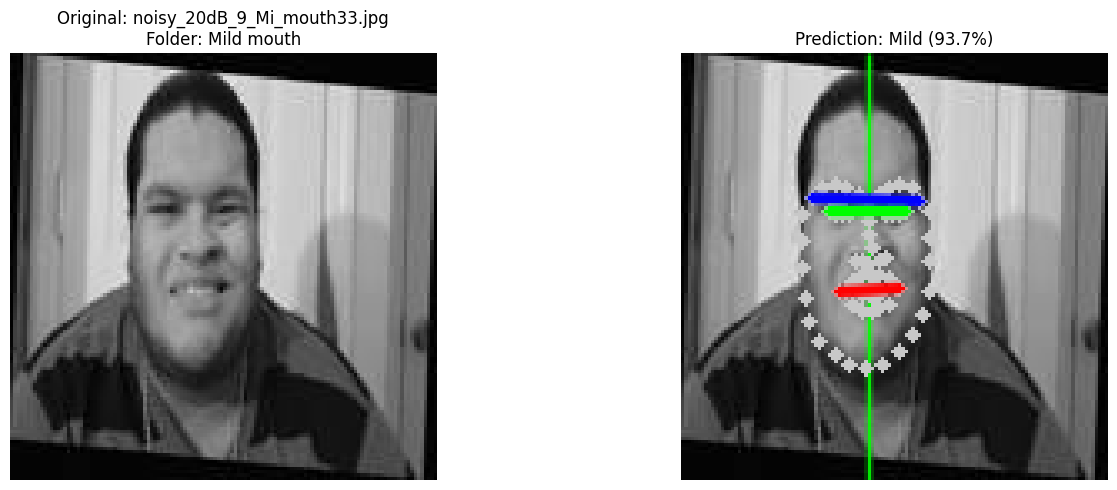

Streaming output truncated to the last 5000 lines.
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: 0.00°
  Eye angle:     1.91°
  Mouth angle:   8.53°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 91.44%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 1.98%
  Mild: 91.44%
  Moderate: 1.52%
  Severe: 5.06%

PROCESSING IMAGE 451/3901: rotated-10_14_Mi_mouth6.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and features...

📊 Extracted Angle Features:
  Eyebrow angle: -16.26°
  Eye angle:     -16.39°
  Mouth angle:   -24.78°

🤖 Making prediction with trained model...

🎯 PREDICTION RESULTS:
  Predicted class: Mild
  Confidence: 94.87%
  Actual folder: Mild mouth

📈 ALL CLASS PROBABILITIES:
  Normal: 0.00%
  Mild: 94.87%
  Moderate: 0.57%
  Severe: 4.56%

PROCESSING IMAGE 452/3901: noisy_20dB_6_Mi_mouth21.jpg
Directory: Mild mouth
📐 Extracting facial landmarks and f

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
import dlib
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import os
import urllib.request
import bz2
import zipfile

# ============================================================================
# UNZIP MOUTH.ZIP
# ============================================================================

def unzip_mouth_data():
    """Unzip mouth.zip if not already extracted"""
    zip_path = "/content/Mouth.zip"
    extract_path = "/content/mouth_analysis"

    if not os.path.exists(extract_path):
        print("📦 Extracting mouth.zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"✅ Extracted to: {extract_path}")
    else:
        print(f"✅ Mouth images already extracted at: {extract_path}")

    return extract_path

# ============================================================================
# MODEL SETUP
# ============================================================================

print("📥 Setting up face detection models...")

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Face detection models loaded successfully\n")

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))
    raise ValueError("No face detected")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = detect_face_dnn(image)
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """Create 6 clusters: left/right for eyebrows, eyes, mouth"""
    clusters = {
        'left_eyebrow': [], 'right_eyebrow': [],
        'left_eye': [], 'right_eye': [],
        'left_mouth': [], 'right_mouth': []
    }

    for i, point in enumerate(landmarks):
        x, y = point
        if 17 <= i <= 26:  # Eyebrow points
            if x < midline_x: clusters['left_eyebrow'].append(point)
            else: clusters['right_eyebrow'].append(point)
        elif 36 <= i <= 47:  # Eye points
            if x < midline_x: clusters['left_eye'].append(point)
            else: clusters['right_eye'].append(point)
        elif 48 <= i <= 67:  # Mouth points
            if x < midline_x: clusters['left_mouth'].append(point)
            else: clusters['right_mouth'].append(point)

    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])
    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """Extract only 3 angle features"""
    features = {}

    # Eyebrow angle
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features):
    """Visualize the analysis without any text on the image"""
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Find midline for visualization
    midline_x = find_midline(landmarks)

    # Draw midline
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)

    # Draw landmarks
    for point in landmarks:
        cv2.circle(vis_img, tuple(point.astype(int)), 2, (200, 200, 200), -1)

    # Draw angle lines
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 0, 0), 2, cv2.LINE_AA)

    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (0, 255, 0), 2, cv2.LINE_AA)

    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (0, 0, 255), 2, cv2.LINE_AA)

    return vis_img

# ============================================================================
# LOAD TRAINED MODEL (2000 IMAGES PER CLASS)
# ============================================================================

def load_trained_model():
    """Load the trained Random Forest model trained on 2000 images per class"""
    print("📊 Loading trained model (2000 images per class)...")

    model_path = "/content/facial_palsy_rf_model_equal_2000perclass.pkl"
    info_path = "/content/model_info_equal_2000perclass.pkl"

    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)

        with open(info_path, 'rb') as f:
            model_info = pickle.load(f)

        print("✅ Model loaded successfully!")
        print(f"   Model type: Random Forest")
        print(f"   Classes: {model_info['class_names']}")
        print(f"   Features: {model_info['feature_names']}")
        print(f"   Samples per class: {model_info.get('samples_per_class', 'N/A')}")
        print(f"   Total samples: {model_info.get('total_samples', 'N/A')}")
        print(f"   Test accuracy: {model_info.get('test_accuracy', 'N/A')}")

        return model, model_info

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("💡 Make sure you have trained the model with 2000 images per class first")
        return None, None

# ============================================================================
# PROCESS MOUTH IMAGES AND MAKE PREDICTIONS
# ============================================================================

def process_mouth_images_and_predict():
    """Process mouth directory images and apply the trained model"""

    print("\n" + "="*80)
    print("PROCESSING MOUTH IMAGES WITH TRAINED MODEL (2000 IMAGES PER CLASS)")
    print("="*80)

    # Unzip mouth.zip first
    mouth_dir = Path(unzip_mouth_data())

    # Load the trained model
    model, model_info = load_trained_model()
    if model is None:
        return

    class_names = model_info['class_names']
    feature_names = model_info['feature_names']

    # Find all subdirectories
    subdirs = [d for d in mouth_dir.iterdir() if d.is_dir()]
    print(f"\n📁 Found {len(subdirs)} subdirectories:")
    for subdir in subdirs:
        print(f"   • {subdir.name}")

    # Find all mouth images from all subdirectories
    mouth_images = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        mouth_images.extend(mouth_dir.rglob(ext))

    print(f"\n🔍 Found {len(mouth_images)} total mouth images")

    if not mouth_images:
        print("❌ No images found in the mouth directory")
        return

    # Process all images (or limit if you want)
    results = []
    errors = []

    for i, image_path in enumerate(mouth_images):
        print(f"\n{'='*60}")
        print(f"PROCESSING IMAGE {i+1}/{len(mouth_images)}: {image_path.name}")
        print(f"Directory: {image_path.parent.name}")
        print(f"{'='*60}")

        try:
            # Load image
            image = cv2.imread(str(image_path))
            if image is None:
                print(f"❌ Could not load image: {image_path}")
                errors.append({'image': str(image_path), 'error': 'Could not load image'})
                continue

            # Extract features
            print("📐 Extracting facial landmarks and features...")
            landmarks, face = get_landmarks(image)
            midline_x = find_midline(landmarks)
            clusters = create_clusters(landmarks, midline_x)
            features = extract_angle_features(clusters, landmarks)

            # Display extracted features
            print(f"\n📊 Extracted Angle Features:")
            print(f"  Eyebrow angle: {features['eyebrow_angle']:.2f}°")
            print(f"  Eye angle:     {features['eye_angle']:.2f}°")
            print(f"  Mouth angle:   {features['mouth_angle']:.2f}°")

            # Prepare features for prediction
            feature_array = np.array([[
                features['eyebrow_angle'],
                features['eye_angle'],
                features['mouth_angle']
            ]])

            # Make prediction
            print("\n🤖 Making prediction with trained model...")
            prediction = model.predict(feature_array)[0]
            probabilities = model.predict_proba(feature_array)[0]

            # Display results
            print(f"\n🎯 PREDICTION RESULTS:")
            if 0 <= prediction < len(class_names):
                print(f"  Predicted class: {class_names[prediction]}")
                print(f"  Confidence: {probabilities[prediction]:.2%}")
                print(f"  Actual folder: {image_path.parent.name}")
            else:
                print(f"  Predicted class: Unknown (Index out of range: {prediction})")
                print(f"  Confidence: N/A")

            print(f"\n📈 ALL CLASS PROBABILITIES:")
            if len(class_names) == len(probabilities):
                for class_idx, prob in enumerate(probabilities):
                    print(f"  {class_names[class_idx]}: {prob:.2%}")
            else:
                print("  Cannot display probabilities: Mismatch between class names and probabilities length.")

            # Create visualization for first 10 images only (to avoid too many plots)
            if i < 10:
                vis_img = visualize_analysis(image, landmarks, clusters, features)

                plt.figure(figsize=(15, 5))

                # Original image
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(f'Original: {image_path.name}\nFolder: {image_path.parent.name}')
                plt.axis('off')

                # Analysis
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                if 0 <= prediction < len(class_names):
                    plt.title(f'Prediction: {class_names[prediction]} ({probabilities[prediction]:.1%})')
                else:
                    plt.title('Prediction: Unknown')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            # Store results
            if 0 <= prediction < len(class_names):
                result = {
                    'image_path': str(image_path),
                    'image_name': image_path.name,
                    'folder_name': image_path.parent.name,
                    'eyebrow_angle': features['eyebrow_angle'],
                    'eye_angle': features['eye_angle'],
                    'mouth_angle': features['mouth_angle'],
                    'predicted_class': prediction,
                    'predicted_class_name': class_names[prediction],
                    'confidence': probabilities[prediction],
                    'all_probabilities': probabilities.tolist()
                }
                results.append(result)
            else:
                errors.append({'image': str(image_path), 'error': f'Invalid prediction index: {prediction}'})

        except Exception as e:
            print(f"❌ Error processing {image_path.name}: {e}")
            errors.append({'image': str(image_path), 'error': str(e)})
            continue

    # Save results to CSV
    if results:
        results_df = pd.DataFrame(results)
        results_csv_path = "/content/mouth_image_predictions_2000model.csv"
        results_df.to_csv(results_csv_path, index=False)
        print(f"\n💾 Results saved to: {results_csv_path}")

        # Print summary by folder
        print(f"\n📊 PREDICTION SUMMARY BY FOLDER:")
        for folder in results_df['folder_name'].unique():
            folder_df = results_df[results_df['folder_name'] == folder]
            print(f"\n  📁 {folder}:")
            pred_counts = folder_df['predicted_class_name'].value_counts()
            for class_name, count in pred_counts.items():
                percentage = (count / len(folder_df)) * 100
                print(f"     • {class_name}: {count} images ({percentage:.1f}%)")

        # Overall summary
        print(f"\n📊 OVERALL PREDICTION SUMMARY:")
        prediction_counts = results_df['predicted_class_name'].value_counts()
        for class_name, count in prediction_counts.items():
            percentage = (count / len(results_df)) * 100
            print(f"  {class_name}: {count} images ({percentage:.1f}%)")

    # Save errors if any
    if errors:
        errors_df = pd.DataFrame(errors)
        errors_csv_path = "/content/mouth_image_errors.csv"
        errors_df.to_csv(errors_csv_path, index=False)
        print(f"\n⚠️  {len(errors)} errors encountered. Saved to: {errors_csv_path}")

    return results, errors

# ============================================================================
# RUN THE PROCESSING
# ============================================================================

if __name__ == "__main__":
    # Process mouth images and make predictions
    results, errors = process_mouth_images_and_predict()

    if results:
        print(f"\n✅ Successfully processed {len(results)} images!")
        print(f"📁 Results saved to: /content/mouth_image_predictions_2000model.csv")
        if errors:
            print(f"⚠️  {len(errors)} images had errors - check: /content/mouth_image_errors.csv")
    else:
        print(f"\n❌ No images were successfully processed.")

📥 Setting up face detection models...
✅ Face detection models loaded successfully


FACIAL PALSY DETECTION SYSTEM

PROCESSING IMAGES: MILD, MODERATE, SEVERE + 100 NORMAL FROM KAGGLE
✅ Mouth images already extracted at: /content/mouth_analysis

📥 Downloading Kaggle face-vae dataset for Normal class...
✅ Path to dataset files: /root/.cache/kagglehub/datasets/kushsheth/face-vae/versions/1
📊 Found 202599 images in Kaggle dataset
📋 Copying 100 random images as Normal class...
✅ Copied 100 images to Normal_Kaggle folder
📊 Loading trained model (2000 images per class)...
✅ Model loaded successfully!
   Model type: Random Forest
   Classes: ['Normal', 'Mild', 'Moderate', 'Severe']
   Features: ['eyebrow_angle', 'eye_angle', 'mouth_angle']
   Samples per class: 2000
   Total samples: 8000
   Test accuracy: 0.90125

📁 Scanning mouth directory for subdirectories...
   Found 2 subdirectories:
   • Normal_Kaggle
   • Mouth

🎯 Collecting images from Mild, Moderate, Severe directories...

   📊 Total 

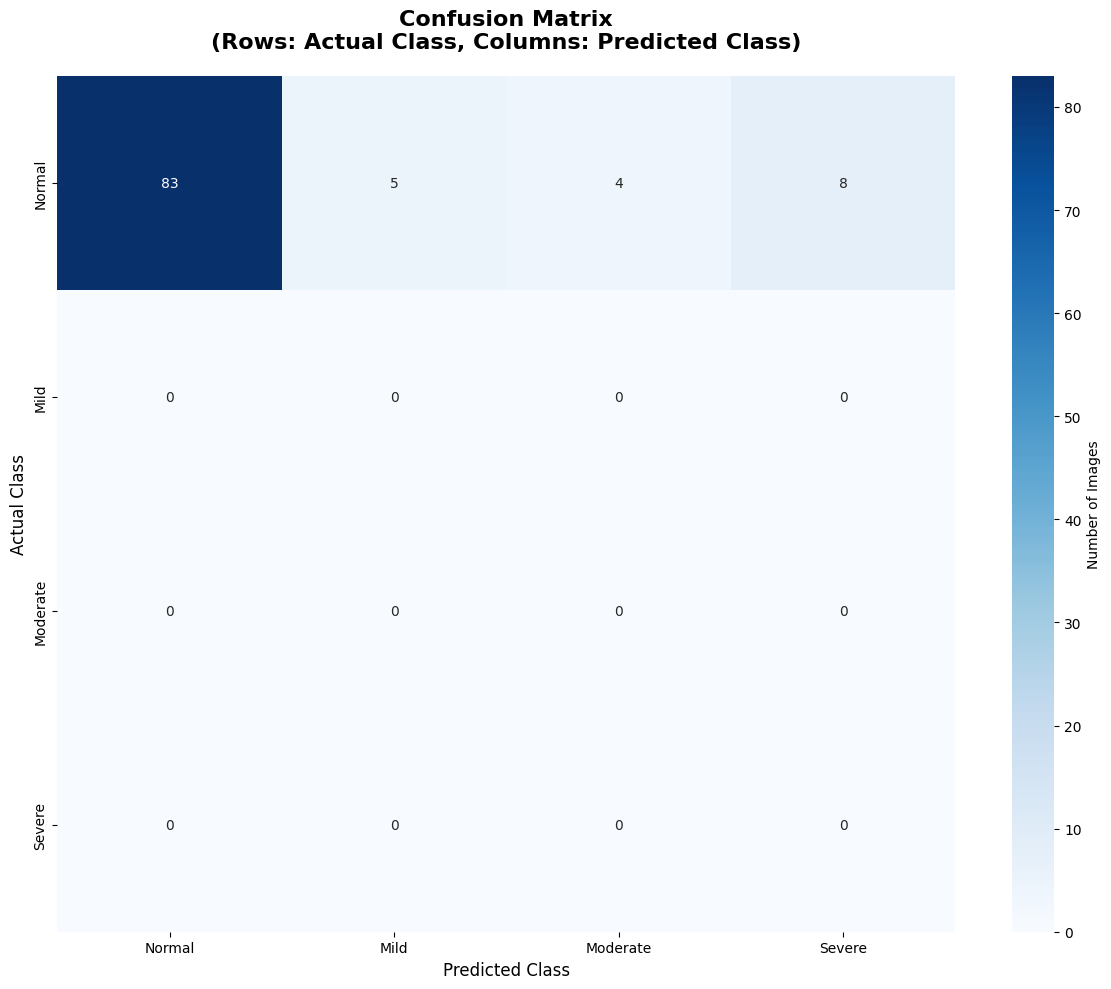


📈 DETAILED TP, TN, FP, FN COUNTS:

Normal:
  ✅ TP:   83 | ✅ TN:    0 | ❌ FP:    0 | ❌ FN:   17
  Precision: 100.00% | Recall: 83.00% | F1: 90.71%

Mild:
  ✅ TP:    0 | ✅ TN:   95 | ❌ FP:    5 | ❌ FN:    0
  Precision: 0.00% | Recall: 0.00% | F1: 0.00%

Moderate:
  ✅ TP:    0 | ✅ TN:   96 | ❌ FP:    4 | ❌ FN:    0
  Precision: 0.00% | Recall: 0.00% | F1: 0.00%

Severe:
  ✅ TP:    0 | ✅ TN:   92 | ❌ FP:    8 | ❌ FN:    0
  Precision: 0.00% | Recall: 0.00% | F1: 0.00%

OVERALL ACCURACY: 83.00% (83/100 correct)

GENERATING VISUALIZATION FOR ALL PREDICTION TYPES...

VISUALIZING ALL PREDICTION TYPES

CLASS: Normal
✅ TRUE POSITIVES: 83 samples (showing 2)
  No True Negatives for Normal
  No False Positives for Normal
❌ FALSE NEGATIVES: 17 samples (showing 2)


/tmp/ipython-input-274375517.py:439: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-274375517.py:439: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


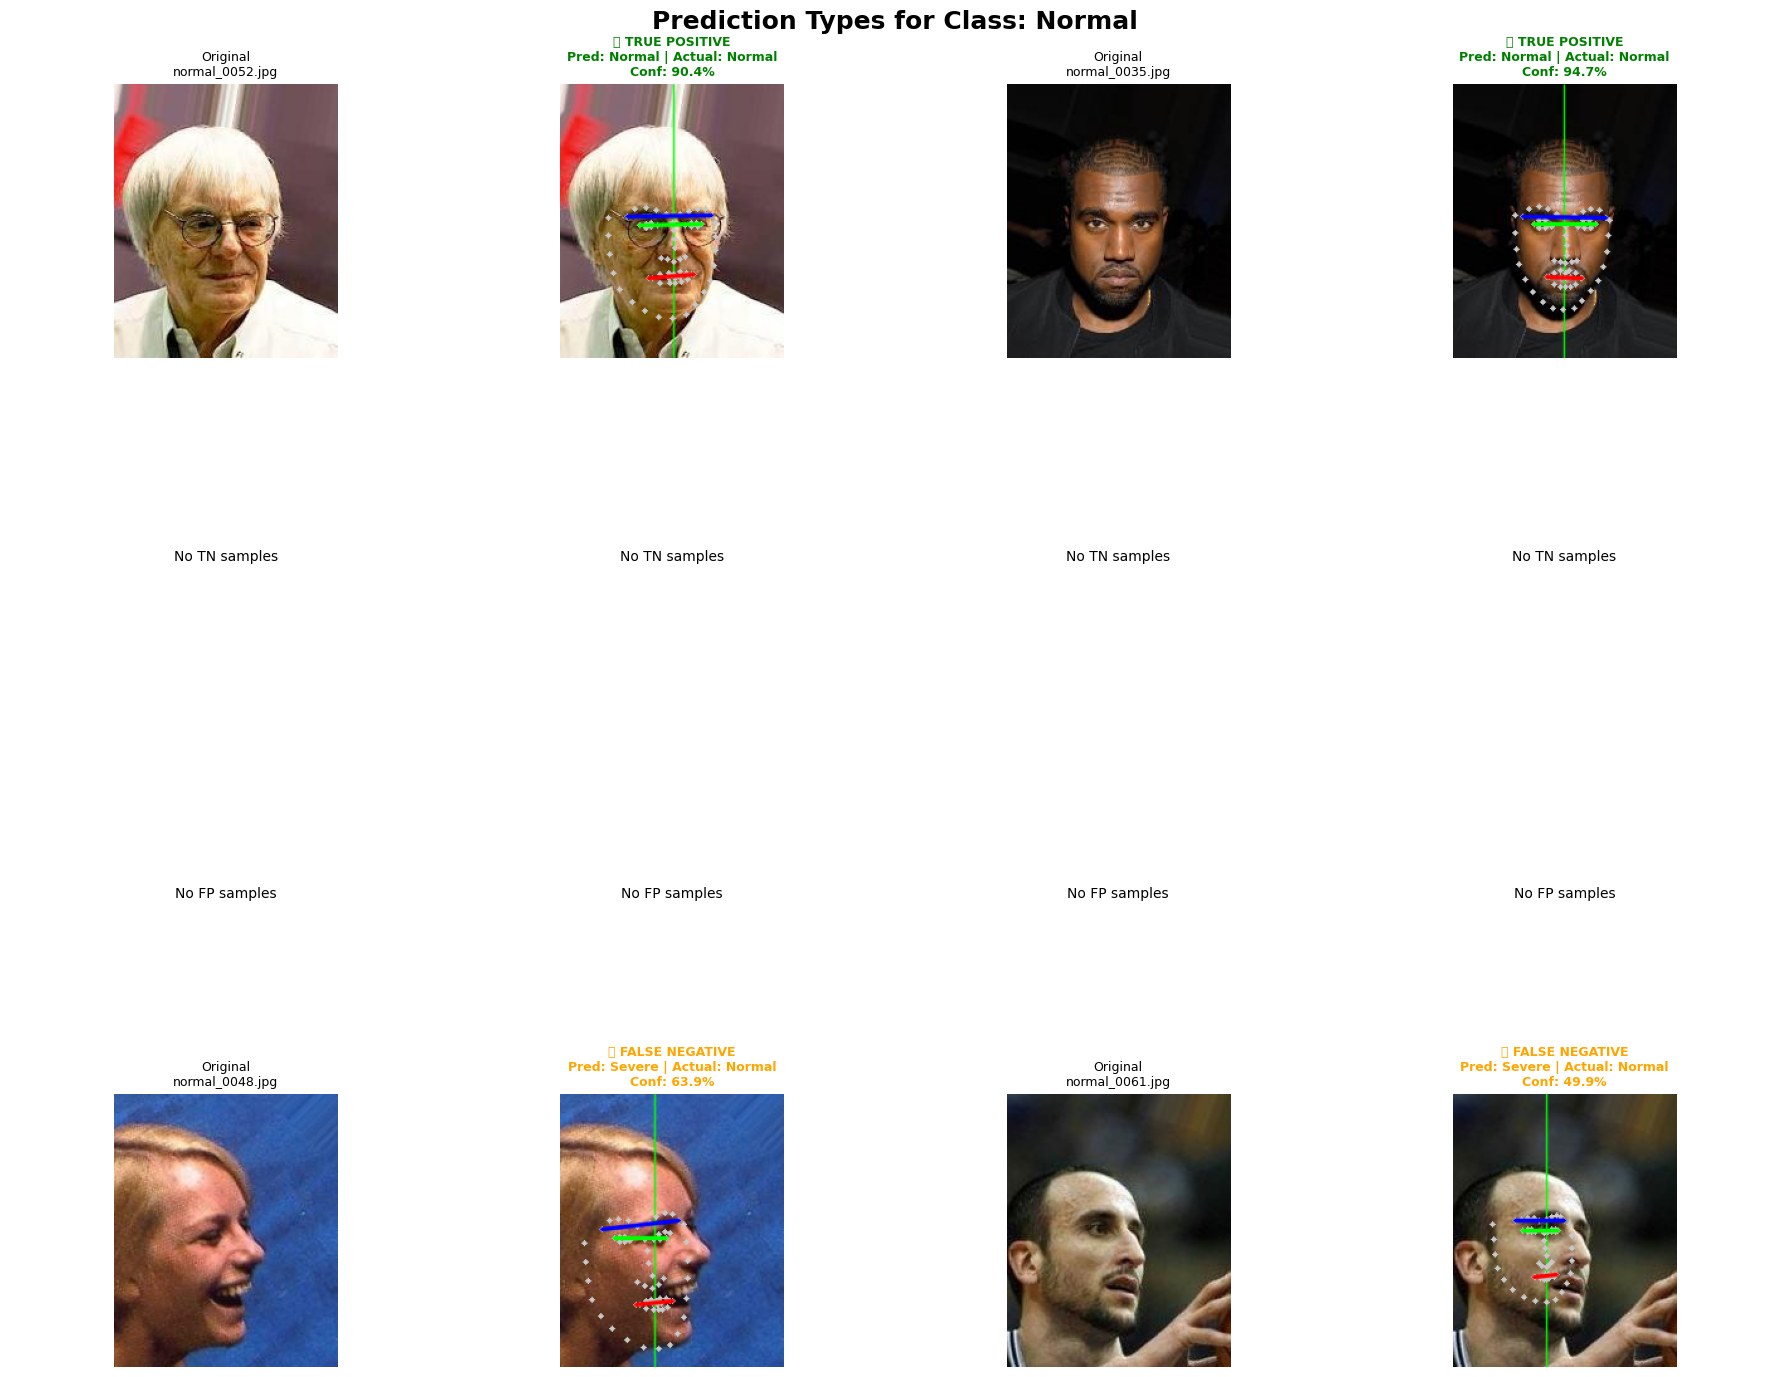


CLASS: Mild
  No True Positives for Mild
✅ TRUE NEGATIVES: 95 samples (showing 2)
❌ FALSE POSITIVES: 5 samples (showing 2)
  No False Negatives for Mild


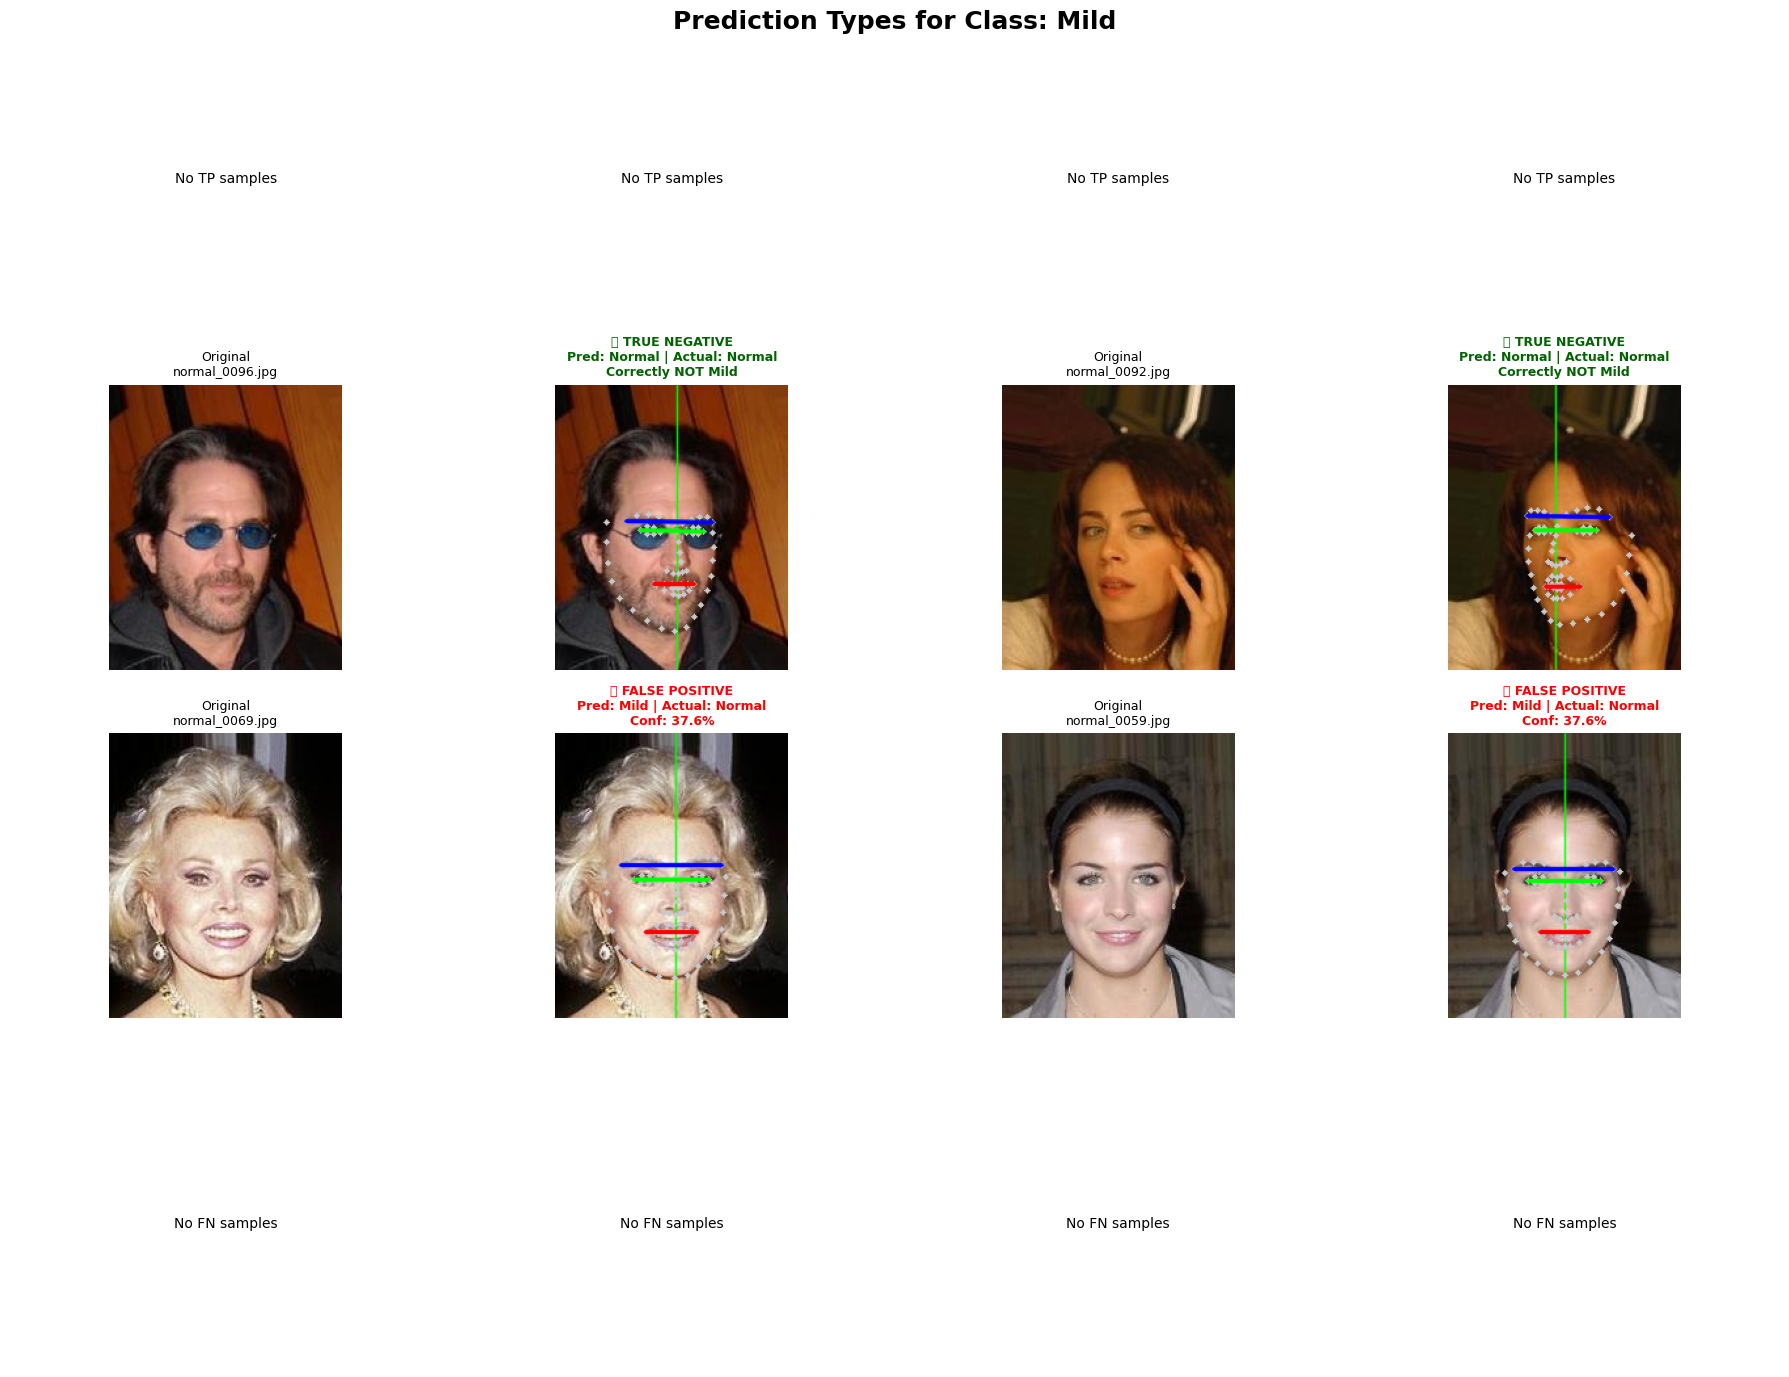


CLASS: Moderate
  No True Positives for Moderate
✅ TRUE NEGATIVES: 96 samples (showing 2)
❌ FALSE POSITIVES: 4 samples (showing 2)
  No False Negatives for Moderate


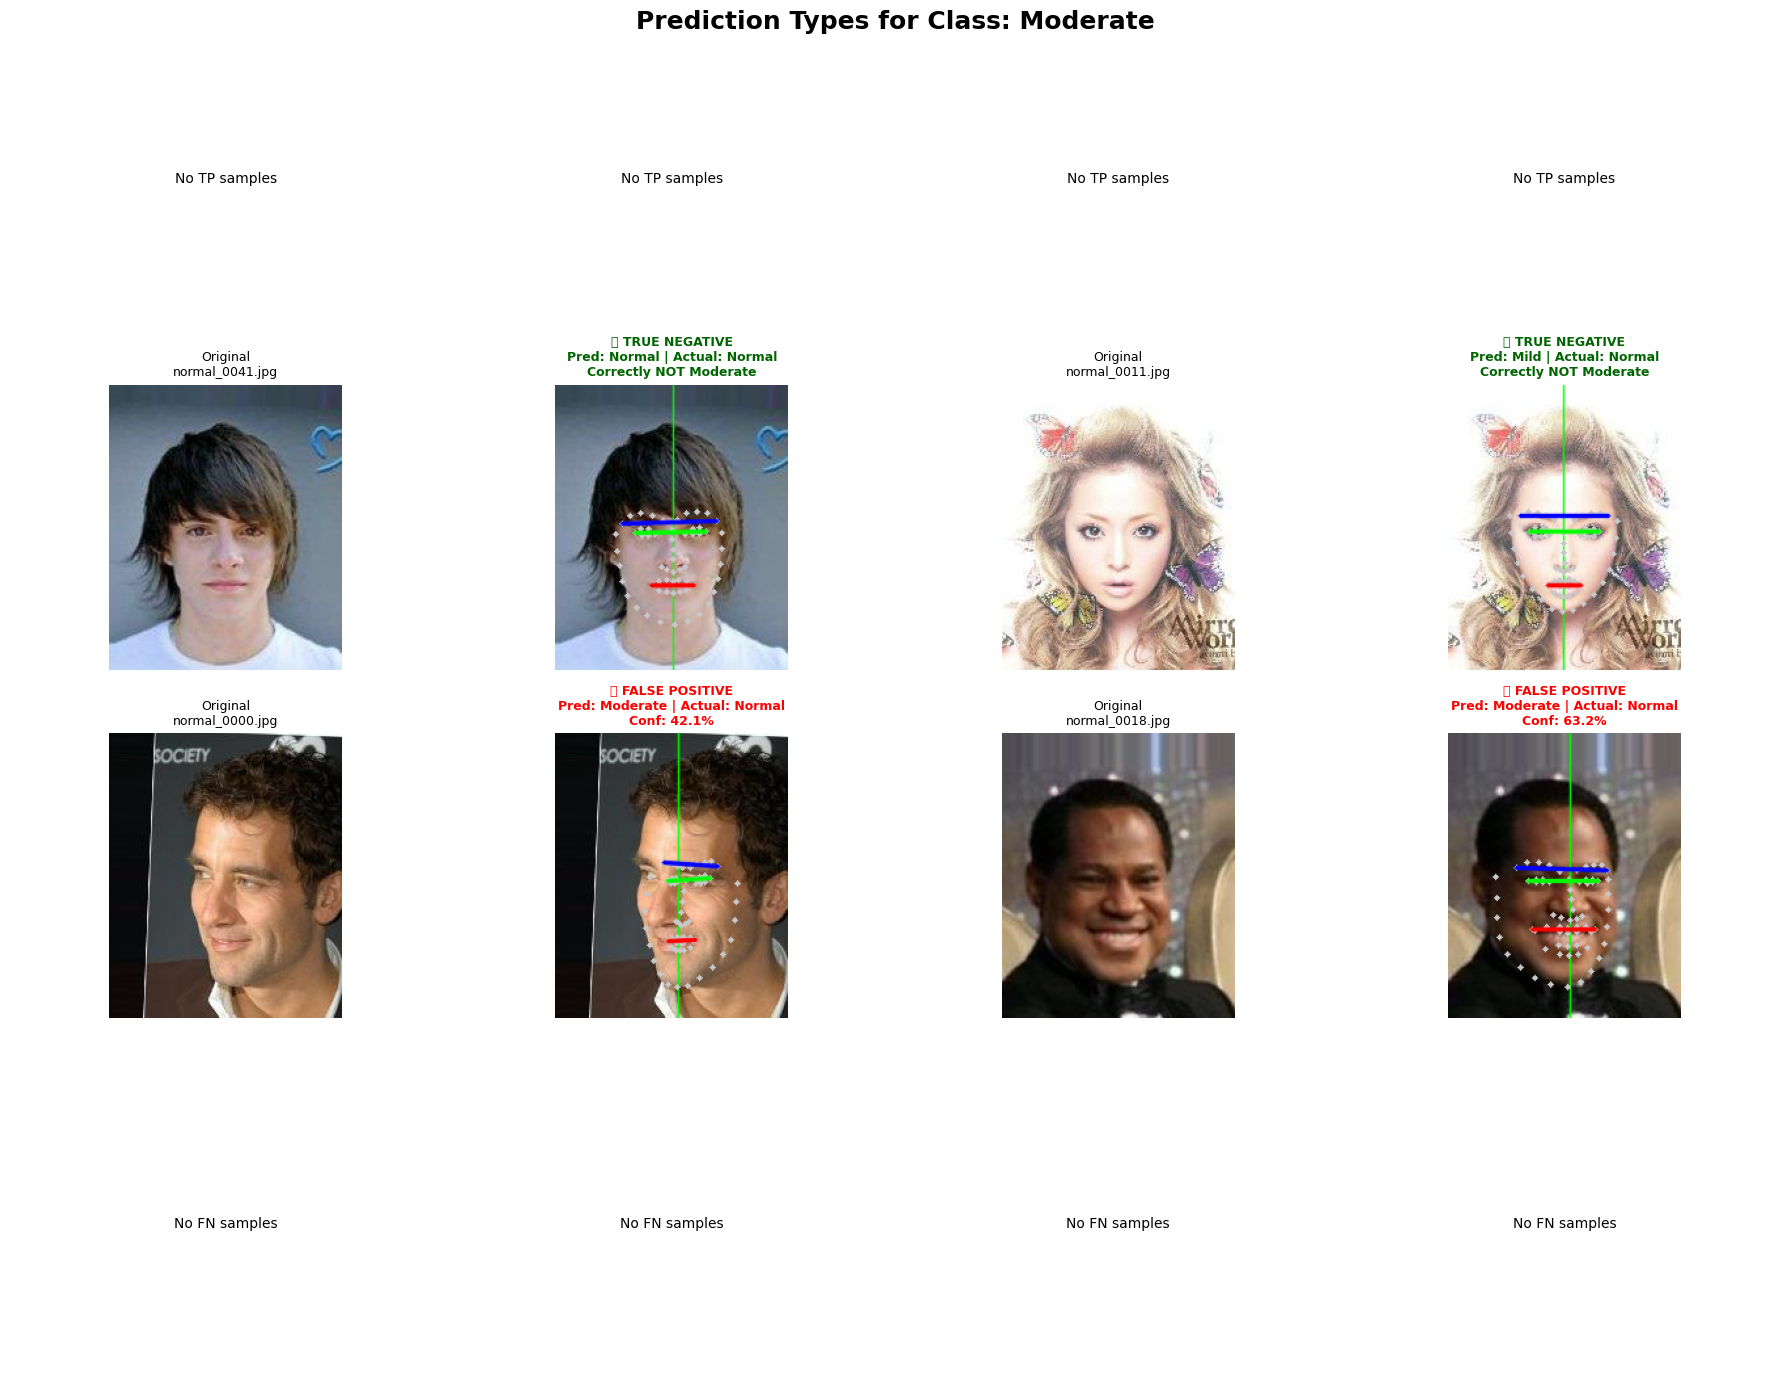


CLASS: Severe
  No True Positives for Severe
✅ TRUE NEGATIVES: 92 samples (showing 2)
❌ FALSE POSITIVES: 8 samples (showing 2)
  No False Negatives for Severe


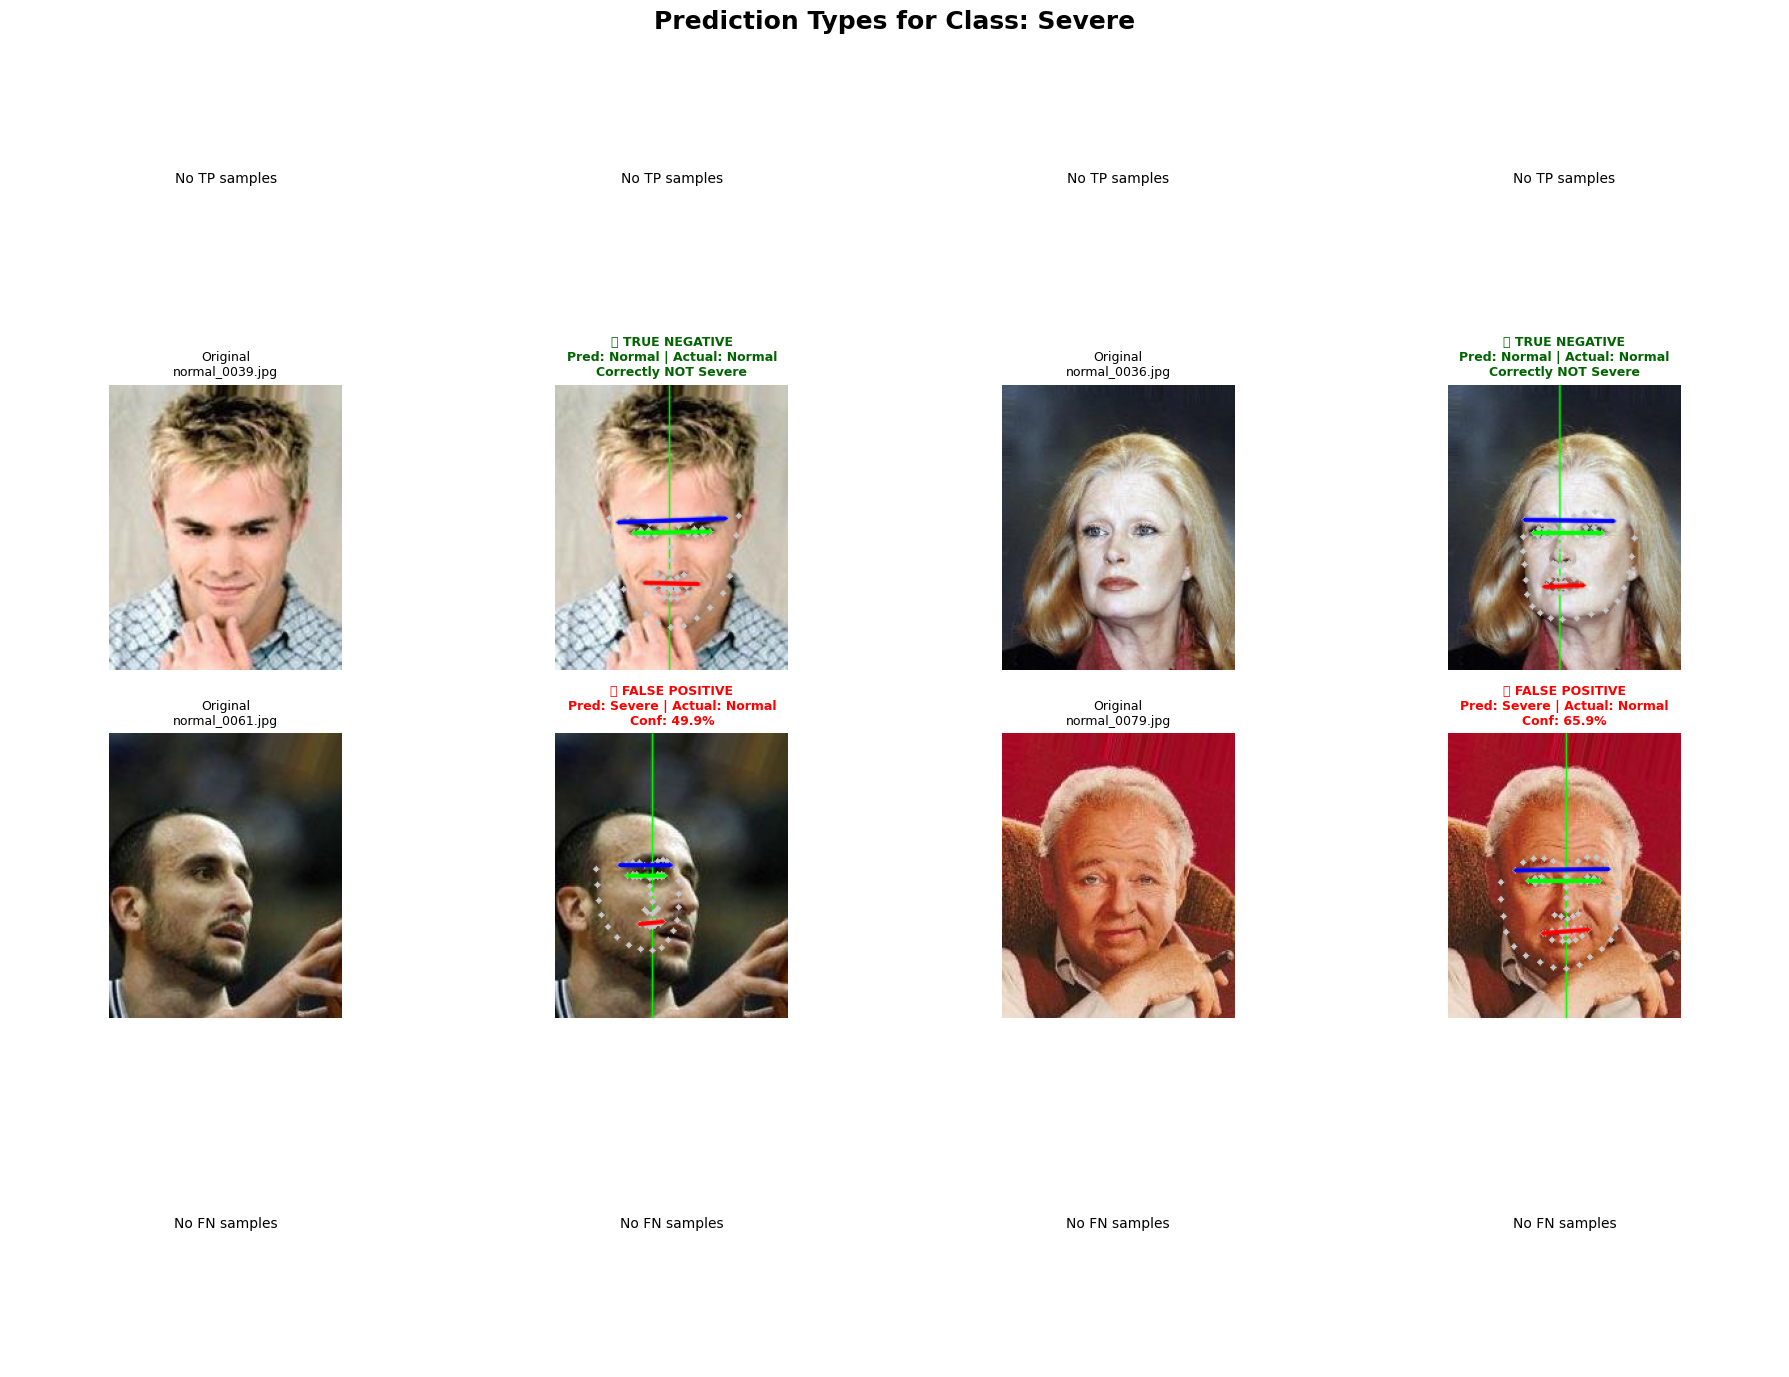


✅ ANALYSIS COMPLETE!
📊 Results saved to CSV
📈 Confusion matrix generated
🎨 Visualizations created for all prediction types


In [ ]:
import cv2
import numpy as np
import dlib
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import os
import urllib.request
import bz2
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import kagglehub

# ============================================================================
# UNZIP MOUTH.ZIP AND SETUP KAGGLE DATASET
# ============================================================================

def unzip_mouth_data():
    """Unzip mouth.zip if not already extracted"""
    zip_path = "/content/Mouth.zip"
    extract_path = "/content/mouth_analysis"

    if not os.path.exists(extract_path):
        print("📦 Extracting mouth.zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"✅ Extracted to: {extract_path}")
    else:
        print(f"✅ Mouth images already extracted at: {extract_path}")

    return extract_path

def setup_kaggle_normal_images():
    """Download and setup Kaggle face-vae dataset as Normal class"""
    print("\n📥 Downloading Kaggle face-vae dataset for Normal class...")

    try:
        # Download latest version
        path = kagglehub.dataset_download("kushsheth/face-vae")
        print(f"✅ Path to dataset files: {path}")

        # Create destination directory
        normal_dir = Path("/content/mouth_analysis/Normal_Kaggle")
        normal_dir.mkdir(parents=True, exist_ok=True)

        # Find all images in the downloaded dataset
        kaggle_path = Path(path)
        all_images = []
        for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
            all_images.extend(list(kaggle_path.rglob(ext)))

        print(f"📊 Found {len(all_images)} images in Kaggle dataset")

        if len(all_images) == 0:
            print("⚠️  No images found in Kaggle dataset")
            return normal_dir

        # Randomly select 100 images
        import random
        random.seed(42)
        selected_images = random.sample(all_images, min(100, len(all_images)))

        # Copy to Normal directory
        print(f"📋 Copying {len(selected_images)} random images as Normal class...")
        for i, img_path in enumerate(selected_images):
            import shutil
            dest_path = normal_dir / f"normal_{i:04d}{img_path.suffix}"
            shutil.copy(str(img_path), str(dest_path))

        print(f"✅ Copied {len(selected_images)} images to Normal_Kaggle folder")
        return normal_dir

    except Exception as e:
        print(f"❌ Error downloading Kaggle dataset: {e}")
        print("💡 Make sure you have kagglehub installed and configured")
        print("   Run: pip install kagglehub")
        return Path("/content/mouth_analysis/Normal_Kaggle")

# ============================================================================
# MODEL SETUP
# ============================================================================

print("📥 Setting up face detection models...")

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Face detection models loaded successfully\n")

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))
    raise ValueError("No face detected")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = detect_face_dnn(image)
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """Create 6 clusters: left/right for eyebrows, eyes, mouth"""
    clusters = {
        'left_eyebrow': [], 'right_eyebrow': [],
        'left_eye': [], 'right_eye': [],
        'left_mouth': [], 'right_mouth': []
    }

    for i, point in enumerate(landmarks):
        x, y = point
        if 17 <= i <= 26:  # Eyebrow points
            if x < midline_x: clusters['left_eyebrow'].append(point)
            else: clusters['right_eyebrow'].append(point)
        elif 36 <= i <= 47:  # Eye points
            if x < midline_x: clusters['left_eye'].append(point)
            else: clusters['right_eye'].append(point)
        elif 48 <= i <= 67:  # Mouth points
            if x < midline_x: clusters['left_mouth'].append(point)
            else: clusters['right_mouth'].append(point)

    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])
    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees (0° = horizontal)"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """Extract only 3 angle features"""
    features = {}

    # Eyebrow angle
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    # Eye angle
    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    # Mouth angle
    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features):
    """Visualize the analysis without any text on the image"""
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    # Find midline for visualization
    midline_x = find_midline(landmarks)

    # Draw midline
    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)

    # Draw landmarks
    for point in landmarks:
        cv2.circle(vis_img, tuple(point.astype(int)), 2, (200, 200, 200), -1)

    # Draw angle lines
    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 0, 0), 2, cv2.LINE_AA)

    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (0, 255, 0), 2, cv2.LINE_AA)

    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (0, 0, 255), 2, cv2.LINE_AA)

    return vis_img

# ============================================================================
# LOAD TRAINED MODEL (2000 IMAGES PER CLASS)
# ============================================================================

def load_trained_model():
    """Load the trained Random Forest model trained on 2000 images per class"""
    print("📊 Loading trained model (2000 images per class)...")

    model_path = "/content/facial_palsy_rf_model_equal_2000perclass.pkl"
    info_path = "/content/model_info_equal_2000perclass.pkl"

    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)

        with open(info_path, 'rb') as f:
            model_info = pickle.load(f)

        print("✅ Model loaded successfully!")
        print(f"   Model type: Random Forest")
        print(f"   Classes: {model_info['class_names']}")
        print(f"   Features: {model_info['feature_names']}")
        print(f"   Samples per class: {model_info.get('samples_per_class', 'N/A')}")
        print(f"   Total samples: {model_info.get('total_samples', 'N/A')}")
        print(f"   Test accuracy: {model_info.get('test_accuracy', 'N/A')}")

        return model, model_info

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("💡 Make sure you have trained the model with 2000 images per class first")
        return None, None

# ============================================================================
# MAP FOLDER NAMES TO CLASS LABELS
# ============================================================================

def map_folder_to_class(folder_name, class_names):
    """Map folder name to standardized class name"""
    folder_lower = folder_name.lower()

    # Check for Normal/Kaggle images
    if 'normal' in folder_lower or 'kaggle' in folder_lower:
        return 'Normal'

    # Create mapping based on keywords for palsy classes
    if 'mild' in folder_lower and 'moderate' not in folder_lower:
        return 'Mild'
    elif 'moderate' in folder_lower and 'severe' in folder_lower:
        return 'Moderate_Severe'
    elif 'moderate' in folder_lower:
        return 'Moderate'
    elif 'severe' in folder_lower:
        return 'Severe'

    return folder_name  # Return as-is if no match

# ============================================================================
# VISUALIZE ALL TYPES OF PREDICTIONS
# ============================================================================

def visualize_all_prediction_types(results, class_names):
    """Visualize True Positives, True Negatives, False Positives, False Negatives"""

    print("\n" + "="*80)
    print("VISUALIZING ALL PREDICTION TYPES")
    print("="*80)

    results_with_images = [r for r in results if 'image' in r and r['image'] is not None]

    if not results_with_images:
        print("❌ No images available for visualization")
        return

    # Convert to dataframe for easier filtering
    df = pd.DataFrame(results_with_images)
    df['actual_class'] = df['folder_name'].apply(lambda x: map_folder_to_class(x, class_names))

    for class_name in class_names:
        print(f"\n{'='*70}")
        print(f"CLASS: {class_name}")
        print(f"{'='*70}")

        # Get correct predictions (True Positives)
        tp = df[(df['actual_class'] == class_name) &
                (df['predicted_class_name'] == class_name)]

        # Get True Negatives (correctly predicted as NOT this class)
        tn = df[(df['actual_class'] != class_name) &
                (df['predicted_class_name'] != class_name)]

        # Get incorrect predictions (False Positives and False Negatives)
        fp = df[(df['actual_class'] != class_name) &
                (df['predicted_class_name'] == class_name)]

        fn = df[(df['actual_class'] == class_name) &
                (df['predicted_class_name'] != class_name)]

        # Create a 2x2 grid for this class
        fig = plt.figure(figsize=(18, 14))
        fig.suptitle(f'Prediction Types for Class: {class_name}', fontsize=18, fontweight='bold', y=0.98)

        # 1. TRUE POSITIVES (Top Left)
        if len(tp) > 0:
            samples = tp.sample(n=min(2, len(tp)), random_state=42)
            print(f"✅ TRUE POSITIVES: {len(tp)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, idx*2 + 1)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, idx*2 + 2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"✅ TRUE POSITIVE\nPred: {class_name} | Actual: {class_name}\nConf: {row['confidence']:.1%}",
                           fontsize=9, color='green', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No True Positives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, i + 1)
                ax.text(0.5, 0.5, 'No TP samples', ha='center', va='center')
                ax.axis('off')

        # 2. TRUE NEGATIVES (Top Right - showing other classes correctly identified)
        if len(tn) > 0:
            samples = tn.sample(n=min(2, len(tn)), random_state=42)
            print(f"✅ TRUE NEGATIVES: {len(tn)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, 5 + idx*2)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, 6 + idx*2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"✅ TRUE NEGATIVE\nPred: {row['predicted_class_name']} | Actual: {row['actual_class']}\nCorrectly NOT {class_name}",
                           fontsize=9, color='darkgreen', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No True Negatives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, 5 + i)
                ax.text(0.5, 0.5, 'No TN samples', ha='center', va='center')
                ax.axis('off')

        # 3. FALSE POSITIVES (Bottom Left)
        if len(fp) > 0:
            samples = fp.sample(n=min(2, len(fp)), random_state=42)
            print(f"❌ FALSE POSITIVES: {len(fp)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, 9 + idx*2)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, 10 + idx*2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"❌ FALSE POSITIVE\nPred: {class_name} | Actual: {row['actual_class']}\nConf: {row['confidence']:.1%}",
                           fontsize=9, color='red', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No False Positives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, 9 + i)
                ax.text(0.5, 0.5, 'No FP samples', ha='center', va='center')
                ax.axis('off')

        # 4. FALSE NEGATIVES (Bottom Right)
        if len(fn) > 0:
            samples = fn.sample(n=min(2, len(fn)), random_state=42)
            print(f"❌ FALSE NEGATIVES: {len(fn)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, 13 + idx*2)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, 14 + idx*2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"❌ FALSE NEGATIVE\nPred: {row['predicted_class_name']} | Actual: {class_name}\nConf: {row['confidence']:.1%}",
                           fontsize=9, color='orange', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No False Negatives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, 13 + i)
                ax.text(0.5, 0.5, 'No FN samples', ha='center', va='center')
                ax.axis('off')

        plt.tight_layout()
        plt.show()

# ============================================================================
# CALCULATE TP, TN, FP, FN AND SHOW CONFUSION MATRIX
# ============================================================================

def calculate_confusion_matrix(results_df, class_names):
    """Calculate and visualize confusion matrix"""

    print("\n" + "="*80)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*80)

    # Map folder names to class names
    results_df['actual_class'] = results_df['folder_name'].apply(
        lambda x: map_folder_to_class(x, class_names)
    )

    # Get actual and predicted labels
    y_true = results_df['actual_class']
    y_pred = results_df['predicted_class_name']

    # Print classification report
    print("\n📊 CLASSIFICATION REPORT:")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Images'})
    plt.title('Confusion Matrix\n(Rows: Actual Class, Columns: Predicted Class)',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print detailed counts
    print("\n📈 DETAILED TP, TN, FP, FN COUNTS:")
    print("="*80)

    for i, class_name in enumerate(class_names):
        tp = ((y_true == class_name) & (y_pred == class_name)).sum()
        tn = ((y_true != class_name) & (y_pred != class_name)).sum()
        fp = ((y_true != class_name) & (y_pred == class_name)).sum()
        fn = ((y_true == class_name) & (y_pred != class_name)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n{class_name}:")
        print(f"  ✅ TP: {tp:4d} | ✅ TN: {tn:4d} | ❌ FP: {fp:4d} | ❌ FN: {fn:4d}")
        print(f"  Precision: {precision:.2%} | Recall: {recall:.2%} | F1: {f1:.2%}")

    # Overall accuracy
    accuracy = (y_true == y_pred).sum() / len(y_true)
    print(f"\n{'='*80}")
    print(f"OVERALL ACCURACY: {accuracy:.2%} ({(y_true == y_pred).sum()}/{len(y_true)} correct)")
    print(f"{'='*80}")

    return cm

# ============================================================================
# PROCESS IMAGES AND MAKE PREDICTIONS - COMPLETED VERSION
# ============================================================================

def process_images_and_predict():
    """Process mouth images (Mild, Moderate, Severe) + 100 normal images"""

    print("\n" + "="*80)
    print("PROCESSING IMAGES: MILD, MODERATE, SEVERE + 100 NORMAL FROM KAGGLE")
    print("="*80)

    # Unzip mouth.zip first
    mouth_dir = Path(unzip_mouth_data())

    # Setup Kaggle normal images (100 images)
    normal_dir = setup_kaggle_normal_images()

    # Load the trained model
    model, model_info = load_trained_model()
    if model is None:
        return None, None

    class_names = model_info['class_names']
    feature_names = model_info['feature_names']

    # Find all subdirectories in mouth directory
    print(f"\n📁 Scanning mouth directory for subdirectories...")
    subdirs = [d for d in mouth_dir.iterdir() if d.is_dir()]
    print(f"   Found {len(subdirs)} subdirectories:")
    for subdir in subdirs:
        print(f"   • {subdir.name}")

    # Collect images from Mild, Moderate, Severe subdirectories only
    print(f"\n🎯 Collecting images from Mild, Moderate, Severe directories...")
    mouth_images = []

    target_categories = ['mild', 'moderate', 'severe']

    for subdir in subdirs:
        subdir_lower = subdir.name.lower()
        # Check if subdirectory matches any target category
        if any(cat in subdir_lower for cat in target_categories):
            images_in_subdir = []
            for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
                images_in_subdir.extend(list(subdir.glob(ext)))

            mouth_images.extend(images_in_subdir)
            print(f"   ✓ {subdir.name}: {len(images_in_subdir)} images found")

    print(f"\n   📊 Total palsy images collected: {len(mouth_images)}")

    # Collect 100 normal images from Kaggle
    normal_images = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        normal_images.extend(list(normal_dir.glob(ext)))

    import random
    random.seed(42)
    if len(normal_images) > 100:
        normal_images = random.sample(normal_images, 100)

    print(f"   ✓ Selected {len(normal_images)} normal images from Kaggle")

    # Combine all images
    all_images = mouth_images + normal_images
    print(f"\n🔍 Total images to process: {len(all_images)}")

    if not all_images:
        print("❌ No images found")
        return None, None

    # Process all images
    results = []
    errors = []

    for i, image_path in enumerate(all_images):
        if i % 20 == 0:
            print(f"Processing: {i+1}/{len(all_images)} images...")

        try:
            # Load image
            image = cv2.imread(str(image_path))
            if image is None:
                errors.append({'image': str(image_path), 'error': 'Could not load image'})
                continue

            # Extract features
            landmarks, face = get_landmarks(image)
            midline_x = find_midline(landmarks)
            clusters = create_clusters(landmarks, midline_x)
            features = extract_angle_features(clusters, landmarks)

            # Prepare features for prediction
            feature_array = np.array([[
                features['eyebrow_angle'],
                features['eye_angle'],
                features['mouth_angle']
            ]])

            # Make prediction
            prediction = model.predict(feature_array)[0]
            probabilities = model.predict_proba(feature_array)[0]

            # Store results with image data for visualization
            if 0 <= prediction < len(class_names):
                result = {
                    'image_path': str(image_path),
                    'image_name': image_path.name,
                    'folder_name': image_path.parent.name,
                    'eyebrow_angle': features['eyebrow_angle'],
                    'eye_angle': features['eye_angle'],
                    'mouth_angle': features['mouth_angle'],
                    'predicted_class': prediction,
                    'predicted_class_name': class_names[prediction],
                    'confidence': probabilities[prediction],
                    'all_probabilities': probabilities.tolist(),
                    'image': image,
                    'landmarks': landmarks,
                    'clusters': clusters,
                    'features': features
                }
                results.append(result)
            else:
                errors.append({'image': str(image_path), 'error': f'Invalid prediction index: {prediction}'})

        except Exception as e:
            errors.append({'image': str(image_path), 'error': str(e)})
            continue

    # Save results to CSV
    if results:
        results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['image', 'landmarks', 'clusters', 'features']}
                                   for r in results])
        results_csv_path = "/content/predictions_palsy_mild_moderate_severe_plus_normal.csv"
        results_df.to_csv(results_csv_path, index=False)
        print(f"\n✅ Results saved to: {results_csv_path}")
        print(f"   Total predictions: {len(results)}")
        print(f"   Total errors: {len(errors)}")

        # Print summary statistics
        print("\n" + "="*80)
        print("PREDICTION SUMMARY")
        print("="*80)
        for class_name in class_names:
            count = (results_df['predicted_class_name'] == class_name).sum()
            percentage = (count / len(results_df)) * 100
            print(f"  {class_name}: {count} images ({percentage:.1f}%)")

        # Save errors if any
        if errors:
            errors_df = pd.DataFrame(errors)
            errors_csv_path = "/content/prediction_errors.csv"
            errors_df.to_csv(errors_csv_path, index=False)
            print(f"\n⚠️  {len(errors)} errors saved to: {errors_csv_path}")

        return results, results_df
    else:
        print("\n❌ No results to save")
        if errors:
            errors_df = pd.DataFrame(errors)
            errors_csv_path = "/content/prediction_errors.csv"
            errors_df.to_csv(errors_csv_path, index=False)
            print(f"⚠️  {len(errors)} errors saved to: {errors_csv_path}")
        return None, None

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("FACIAL PALSY DETECTION SYSTEM")
    print("="*80)

    # Process images and make predictions
    results, results_df = process_images_and_predict()

    if results and results_df is not None:
        # Get class names from model
        model, model_info = load_trained_model()
        if model is not None:
            class_names = model_info['class_names']

            # Calculate and display confusion matrix
            print("\n" + "="*80)
            print("GENERATING CONFUSION MATRIX...")
            print("="*80)
            cm = calculate_confusion_matrix(results_df, class_names)

            # Visualize all prediction types
            print("\n" + "="*80)
            print("GENERATING VISUALIZATION FOR ALL PREDICTION TYPES...")
            print("="*80)
            visualize_all_prediction_types(results, class_names)

            print("\n" + "="*80)
            print("✅ ANALYSIS COMPLETE!")
            print("="*80)
            print(f"📊 Results saved to CSV")
            print(f"📈 Confusion matrix generated")
            print(f"🎨 Visualizations created for all prediction types")
            print("="*80)
    else:
        print("\n❌ Failed to process images. Please check the errors above.")

📥 Setting up face detection models...
✅ Face detection models loaded successfully


FACIAL PALSY DETECTION - BALANCED DATASET
100 images per class (Mild, Moderate, Severe) + 100 Normal

PROCESSING BALANCED DATASET
✅ Mouth images already extracted at: /content/mouth_analysis

COLLECTING BALANCED DATASET
Target: 100 images per class from all features

🔍 Exploring directory: /content/mouth_analysis
   📁 Found: mild mouth → Mild (Mouth): 603 images
   📁 Found: moderate severe mouth → Moderate (Mouth): 2308 images
   📁 Found: moderate mouth → Moderate (Mouth): 576 images
   📁 Found: severe mouth → Severe (Mouth): 414 images

COLLECTION SUMMARY (Before Balancing)
   Mild: 603 images found
   Moderate: 2884 images found
   Severe: 414 images found

BALANCING DATASET
   ✅ Mild: Selected 100 from 603 available
   ✅ Moderate: Selected 100 from 2884 available
   ✅ Severe: Selected 100 from 414 available

📊 Total images in balanced dataset: 300

📥 Downloading CelebA dataset for Normal class...
Usi

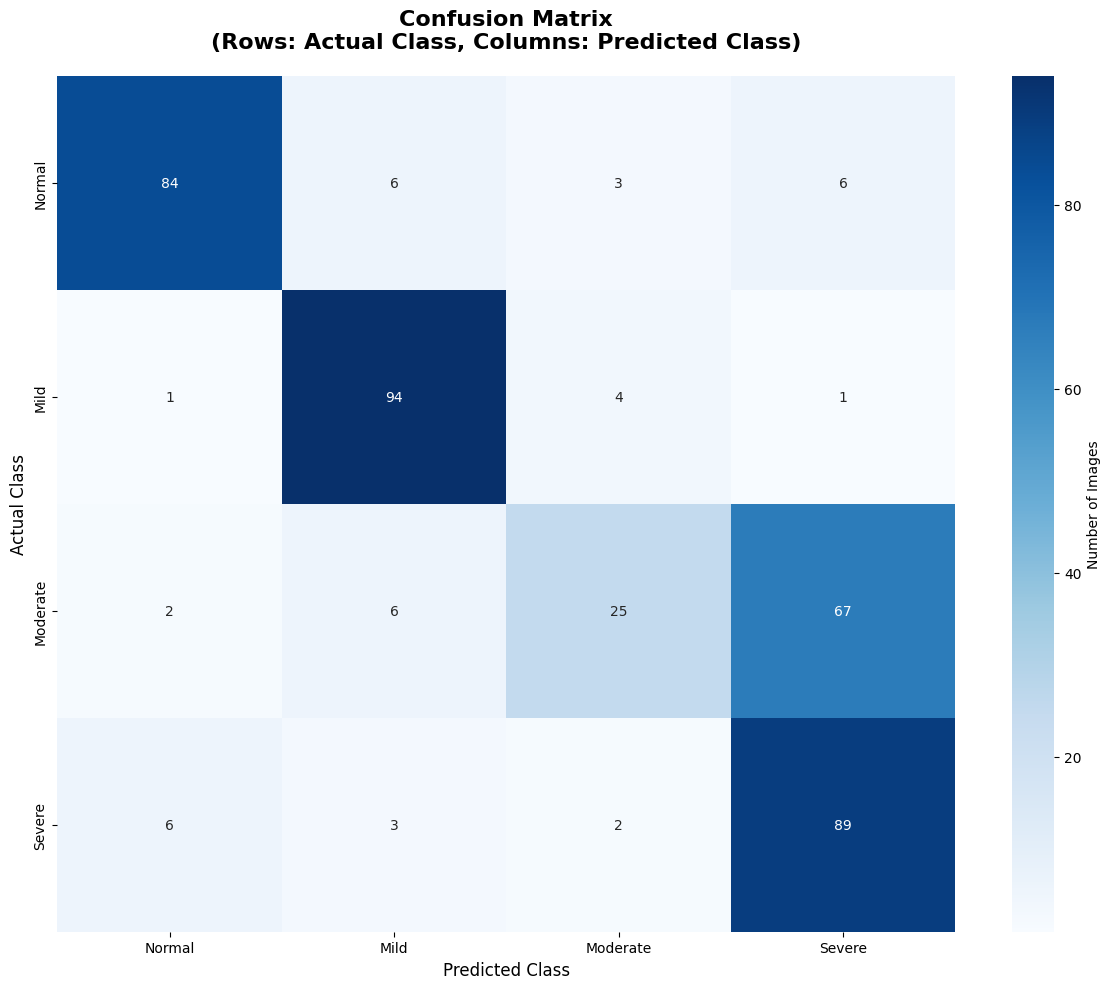


📈 DETAILED TP, TN, FP, FN COUNTS:

Normal:
  ✅ TP:   84 | ✅ TN:  291 | ❌ FP:    9 | ❌ FN:   15
  Precision: 90.32% | Recall: 84.85% | F1: 87.50%

Mild:
  ✅ TP:   94 | ✅ TN:  284 | ❌ FP:   15 | ❌ FN:    6
  Precision: 86.24% | Recall: 94.00% | F1: 89.95%

Moderate:
  ✅ TP:   25 | ✅ TN:  290 | ❌ FP:    9 | ❌ FN:   75
  Precision: 73.53% | Recall: 25.00% | F1: 37.31%

Severe:
  ✅ TP:   89 | ✅ TN:  225 | ❌ FP:   74 | ❌ FN:   11
  Precision: 54.60% | Recall: 89.00% | F1: 67.68%

OVERALL ACCURACY: 73.18% (292/399 correct)

GENERATING VISUALIZATIONS FOR ALL PREDICTION TYPES...

VISUALIZING ALL PREDICTION TYPES

📊 Total valid images for visualization: 399
   Class distribution:
   • Normal: 99 images
   • Mild: 100 images
   • Moderate: 100 images
   • Severe: 100 images

CLASS: Normal
✅ TRUE POSITIVES: 84 samples (showing 2)
✅ TRUE NEGATIVES: 291 samples (showing 2)
❌ FALSE POSITIVES: 9 samples (showing 2)
❌ FALSE NEGATIVES: 15 samples (showing 2)


/tmp/ipython-input-477319873.py:535: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-477319873.py:535: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


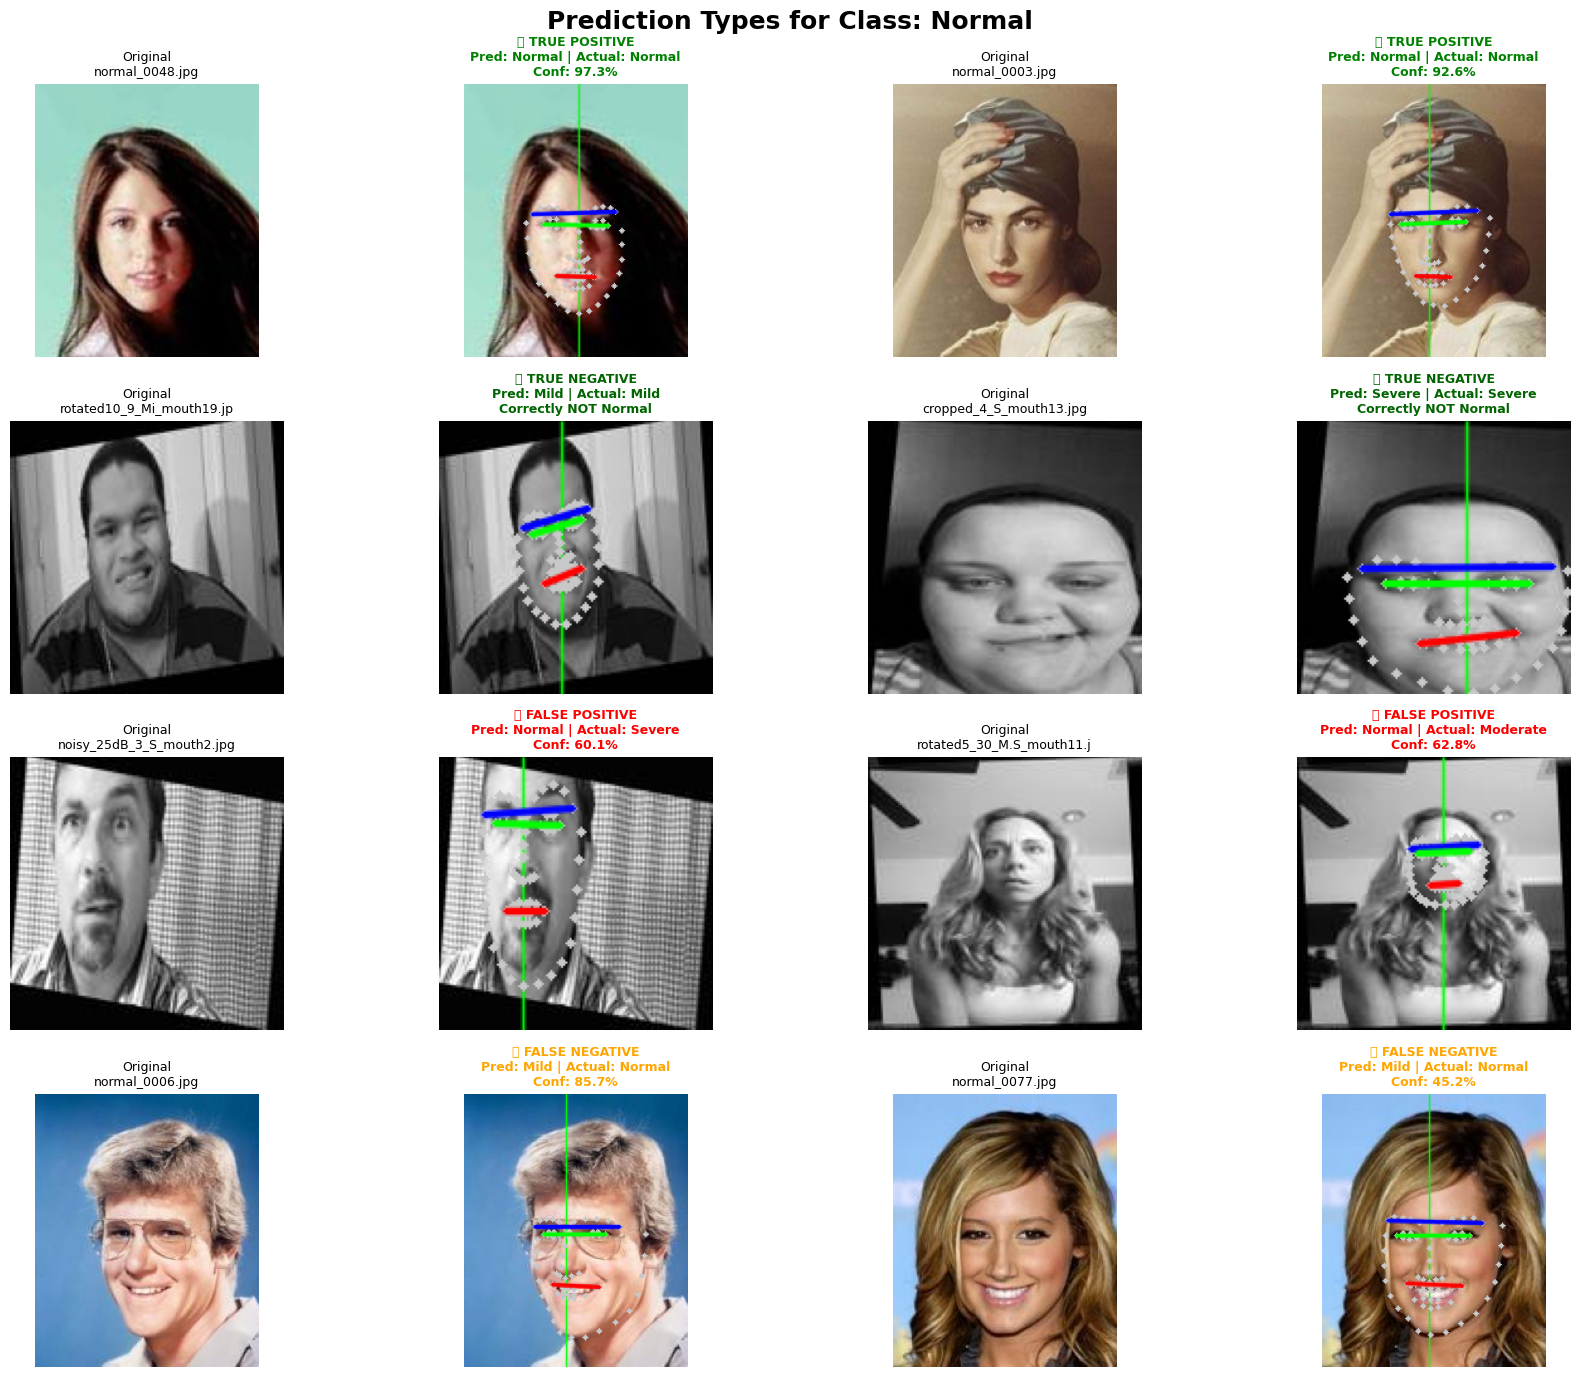


CLASS: Mild
✅ TRUE POSITIVES: 94 samples (showing 2)
✅ TRUE NEGATIVES: 284 samples (showing 2)
❌ FALSE POSITIVES: 15 samples (showing 2)
❌ FALSE NEGATIVES: 6 samples (showing 2)


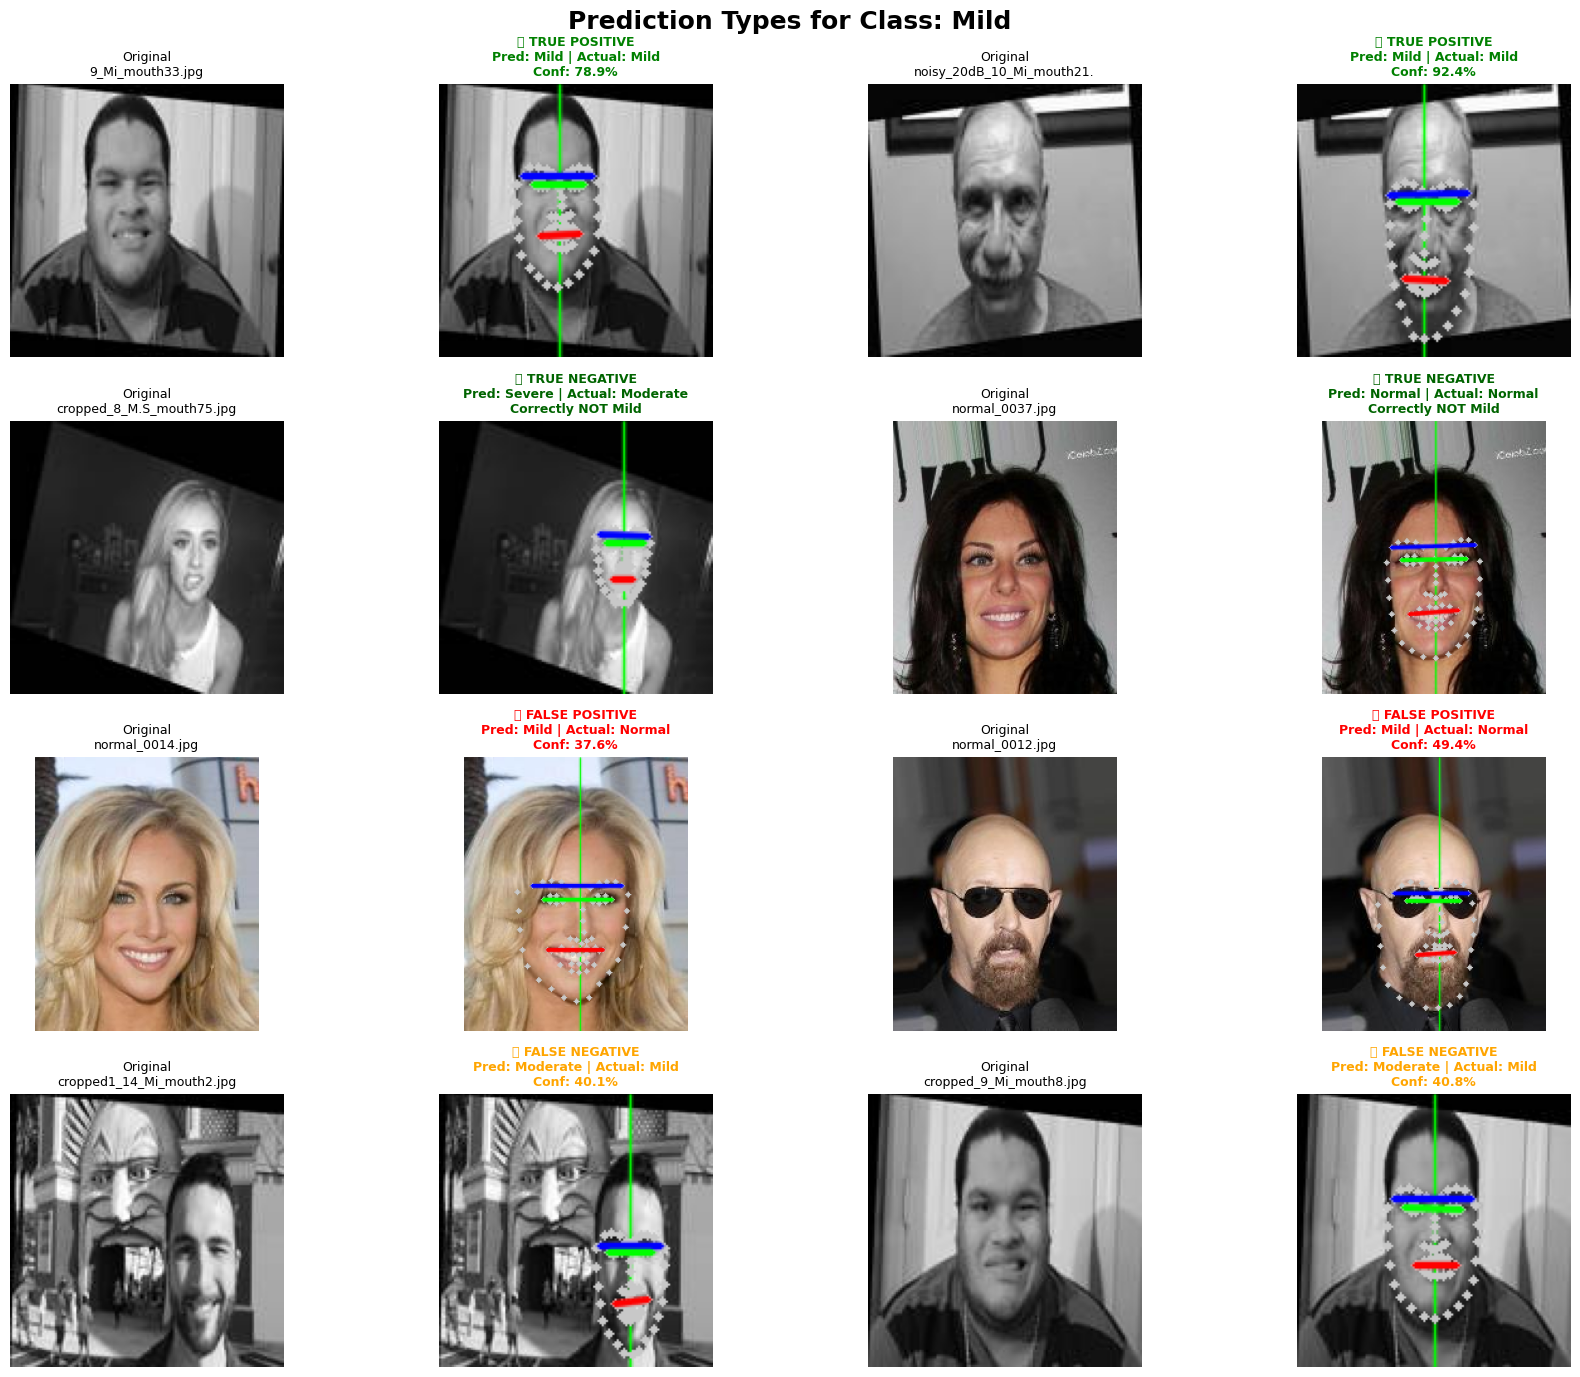


CLASS: Moderate
✅ TRUE POSITIVES: 25 samples (showing 2)
✅ TRUE NEGATIVES: 290 samples (showing 2)
❌ FALSE POSITIVES: 9 samples (showing 2)
❌ FALSE NEGATIVES: 75 samples (showing 2)


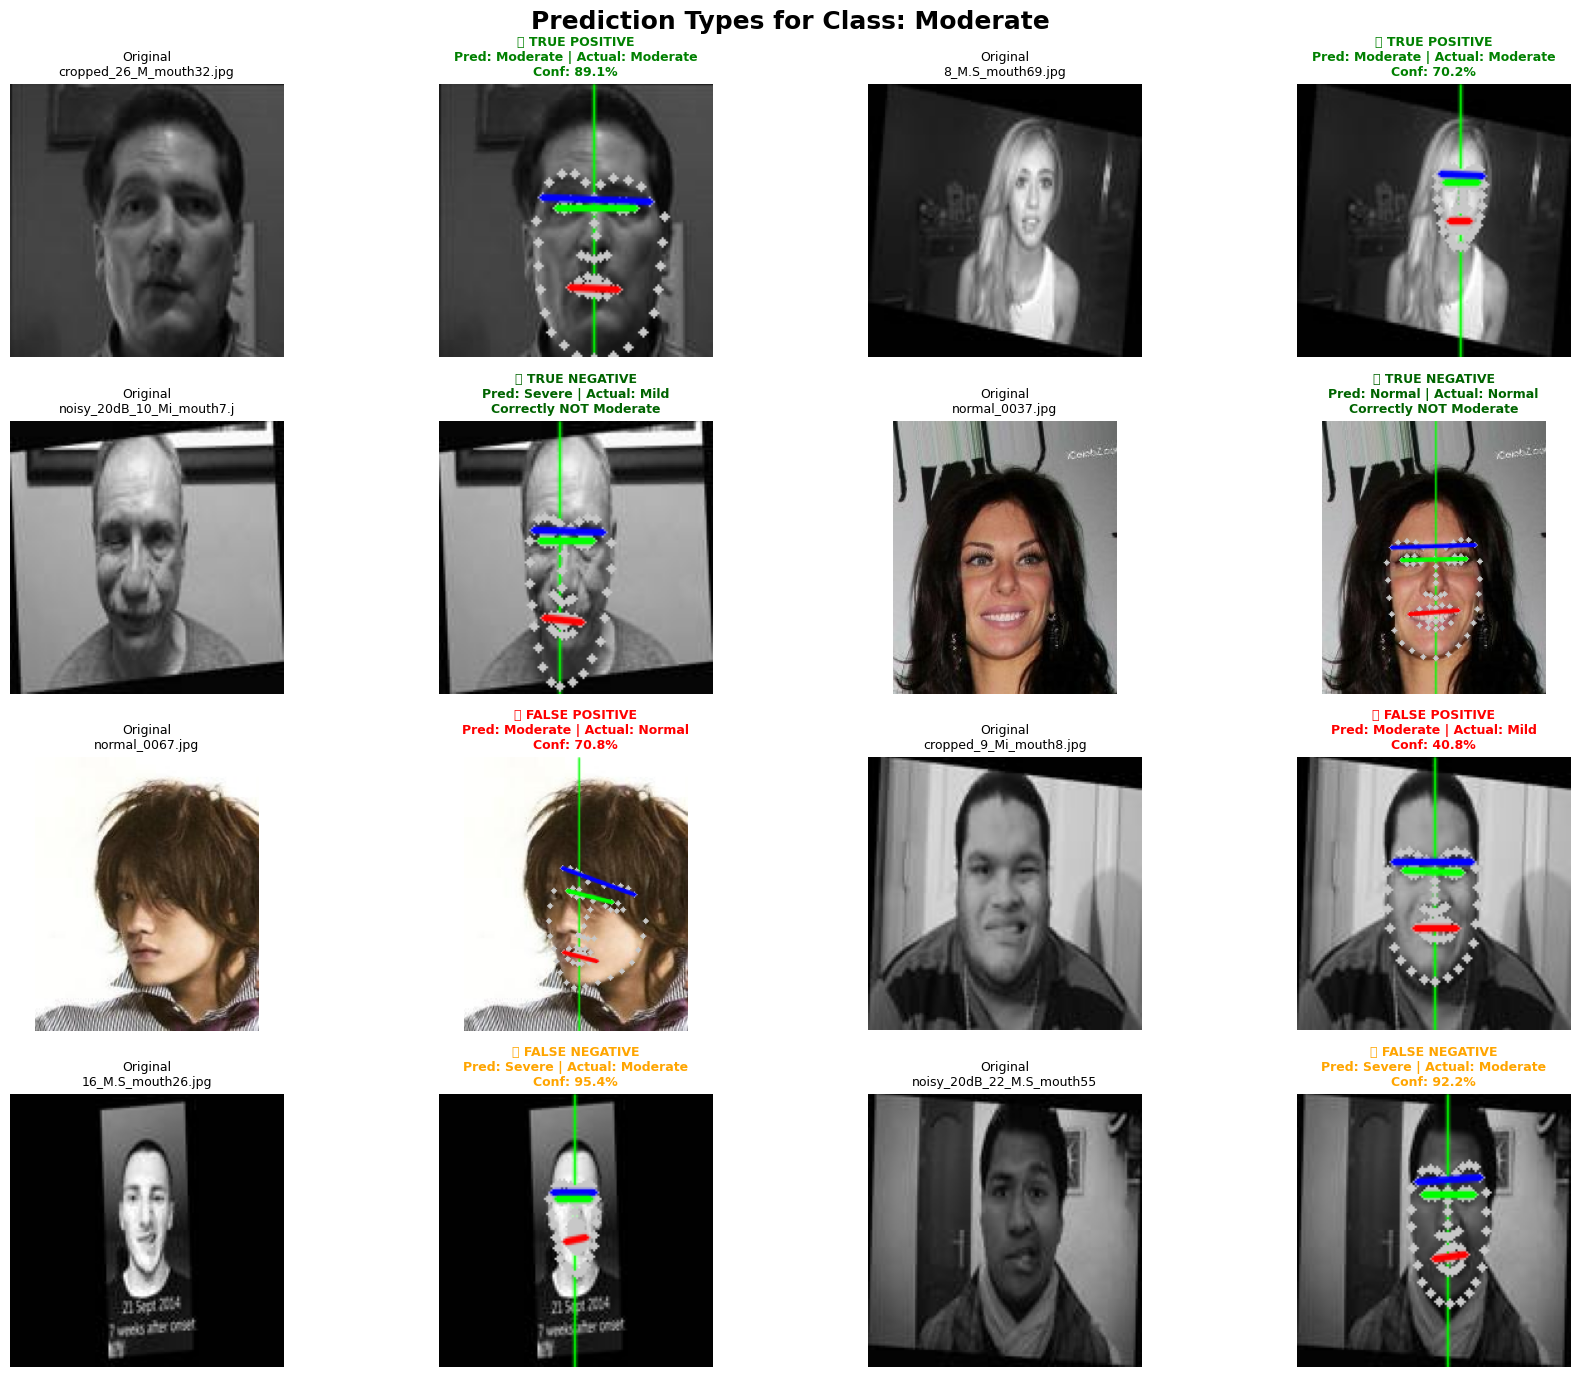


CLASS: Severe
✅ TRUE POSITIVES: 89 samples (showing 2)
✅ TRUE NEGATIVES: 225 samples (showing 2)
❌ FALSE POSITIVES: 74 samples (showing 2)
❌ FALSE NEGATIVES: 11 samples (showing 2)


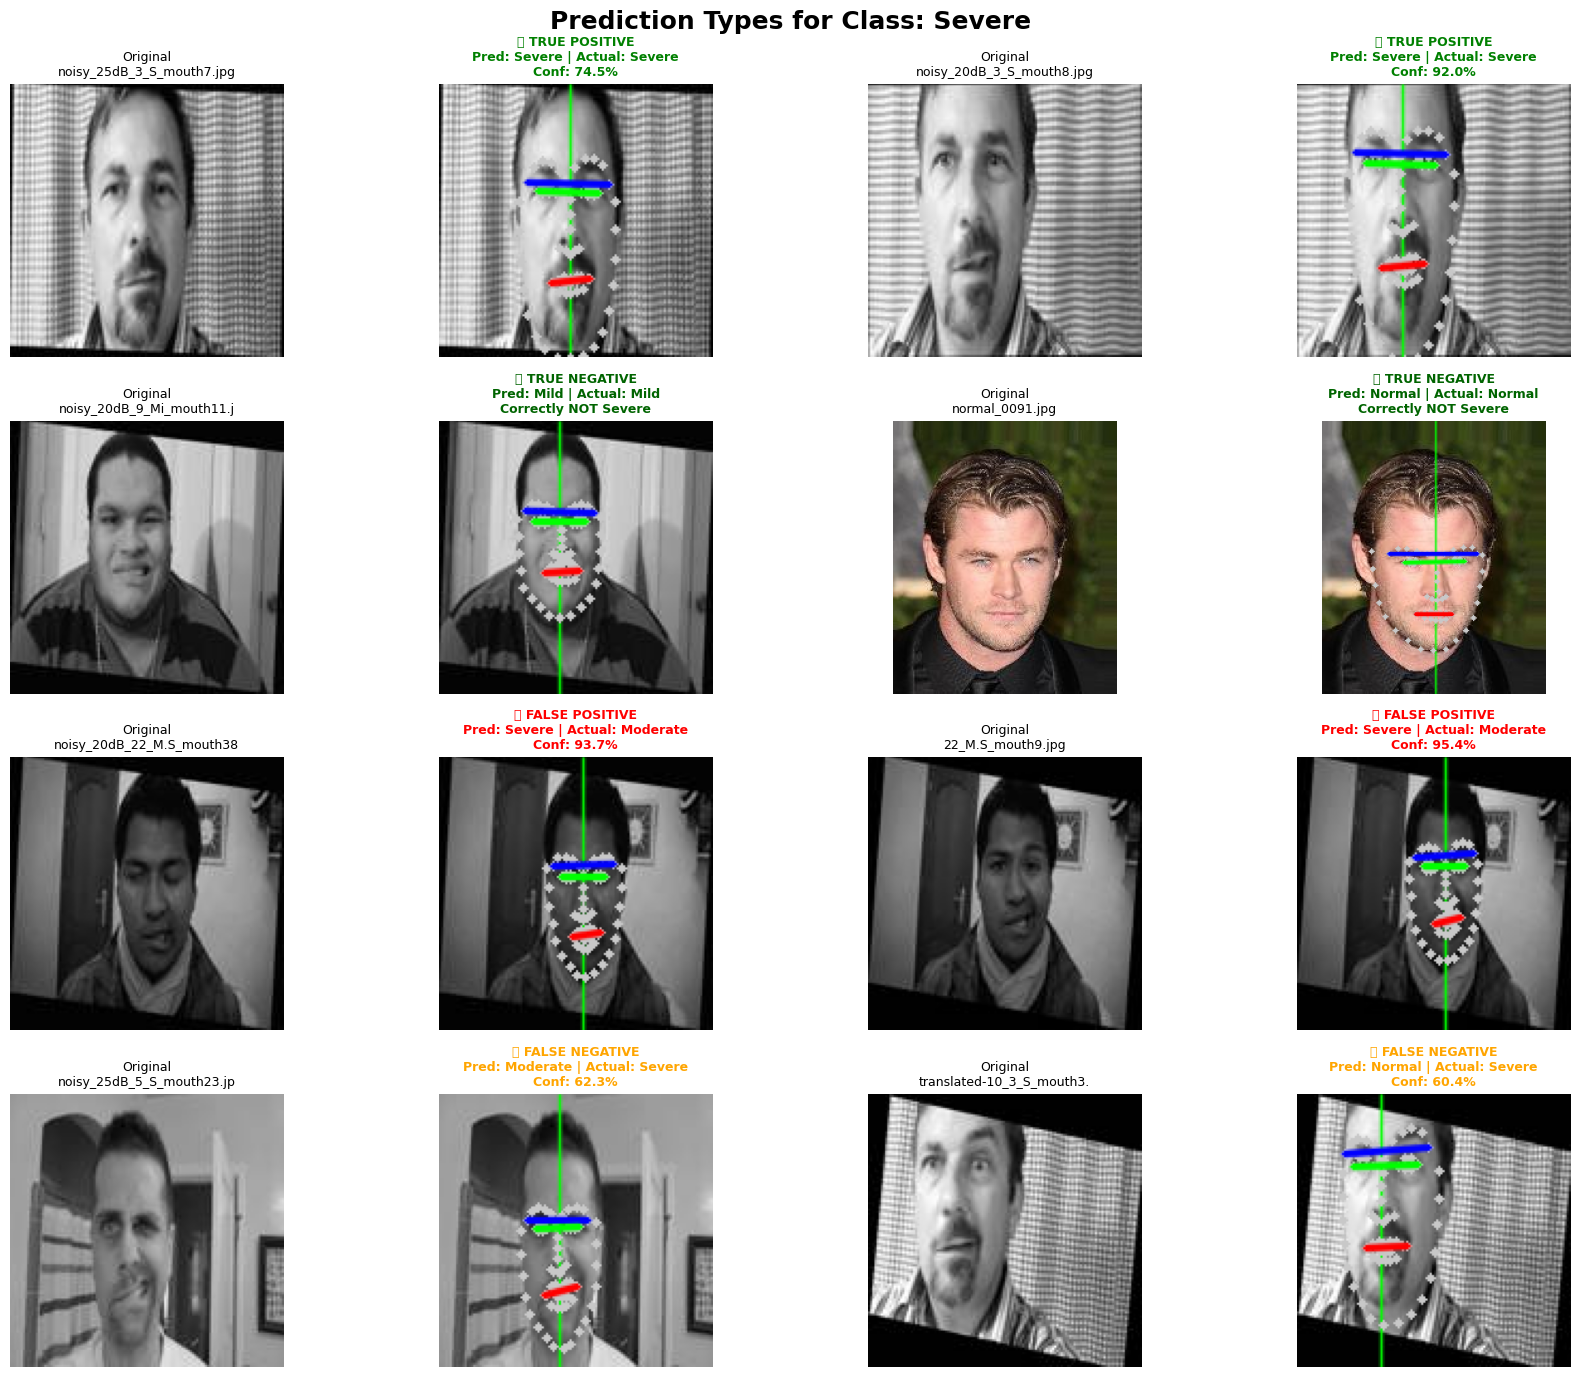


✅ ANALYSIS COMPLETE!
📊 Processed 399 images
   • Mild: ~100 images
   • Moderate: ~100 images
   • Severe: ~100 images
   • Normal: 100 images
📈 Confusion matrix generated
🎨 Visualizations created for all prediction types
💾 Results saved to CSV


In [ ]:
import cv2
import numpy as np
import dlib
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import os
import urllib.request
import bz2
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import kagglehub
import random

# ============================================================================
# UNZIP MOUTH.ZIP AND SETUP KAGGLE DATASET
# ============================================================================

def unzip_mouth_data():
    """Unzip mouth.zip if not already extracted"""
    zip_path = "/content/Mouth.zip"
    extract_path = "/content/mouth_analysis"

    if not os.path.exists(extract_path):
        print("📦 Extracting mouth.zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"✅ Extracted to: {extract_path}")
    else:
        print(f"✅ Mouth images already extracted at: {extract_path}")

    return extract_path

def setup_kaggle_normal_images():
    """Download and setup CelebA dataset as Normal class"""
    print("\n📥 Downloading CelebA dataset for Normal class...")

    try:
        path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
        print(f"✅ Path to dataset files: {path}")

        normal_dir = Path("/content/mouth_analysis/Normal_CelebA")
        normal_dir.mkdir(parents=True, exist_ok=True)

        kaggle_path = Path(path)
        all_images = []

        # CelebA images are typically in img_align_celeba folder
        celeba_img_dir = kaggle_path / "img_align_celeba" / "img_align_celeba"
        if celeba_img_dir.exists():
            print(f"📁 Found CelebA image directory: {celeba_img_dir}")
            for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
                all_images.extend(list(celeba_img_dir.glob(ext)))

        # If not found in expected location, search recursively
        if len(all_images) == 0:
            print("🔍 Searching for images recursively...")
            for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
                all_images.extend(list(kaggle_path.rglob(ext)))

        print(f"📊 Found {len(all_images)} images in CelebA dataset")

        if len(all_images) == 0:
            print("⚠️  No images found in CelebA dataset")
            return normal_dir

        random.seed(42)
        selected_images = random.sample(all_images, min(100, len(all_images)))

        print(f"📋 Copying {len(selected_images)} random images as Normal class...")
        import shutil
        for i, img_path in enumerate(selected_images):
            dest_path = normal_dir / f"normal_{i:04d}{img_path.suffix}"
            shutil.copy(str(img_path), str(dest_path))

        print(f"✅ Copied {len(selected_images)} images to Normal_CelebA folder")
        return normal_dir

    except Exception as e:
        print(f"❌ Error downloading CelebA dataset: {e}")
        return Path("/content/mouth_analysis/Normal_CelebA")

# ============================================================================
# MODEL SETUP
# ============================================================================

print("📥 Setting up face detection models...")

FACE_PROTO = "deploy.prototxt"
FACE_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(FACE_PROTO):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
        FACE_PROTO
    )

if not os.path.exists(FACE_MODEL):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
        FACE_MODEL
    )

LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(LANDMARK_MODEL):
    urllib.request.urlretrieve(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "shape_predictor_68_face_landmarks.dat.bz2"
    )
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2") as f:
        with open(LANDMARK_MODEL, 'wb') as out:
            out.write(f.read())

face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_MODEL)
print("✅ Face detection models loaded successfully\n")

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def detect_face_dnn(image, confidence_threshold=0.5):
    """Detect face using OpenCV DNN"""
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            return dlib.rectangle(int(x1), int(y1), int(x2), int(y2))
    raise ValueError("No face detected")

def get_landmarks(image):
    """Extract 68 facial landmarks from image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = detect_face_dnn(image)
    shape = landmark_predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks, face

def find_midline(landmarks):
    """Find vertical midline of face"""
    nose_tip = landmarks[30]
    chin = landmarks[8]
    midline_x = (nose_tip[0] + chin[0]) / 2
    return midline_x

def create_clusters(landmarks, midline_x):
    """Create 6 clusters: left/right for eyebrows, eyes, mouth"""
    clusters = {
        'left_eyebrow': [], 'right_eyebrow': [],
        'left_eye': [], 'right_eye': [],
        'left_mouth': [], 'right_mouth': []
    }

    for i, point in enumerate(landmarks):
        x, y = point
        if 17 <= i <= 26:
            if x < midline_x: clusters['left_eyebrow'].append(point)
            else: clusters['right_eyebrow'].append(point)
        elif 36 <= i <= 47:
            if x < midline_x: clusters['left_eye'].append(point)
            else: clusters['right_eye'].append(point)
        elif 48 <= i <= 67:
            if x < midline_x: clusters['left_mouth'].append(point)
            else: clusters['right_mouth'].append(point)

    for cluster_name in clusters:
        clusters[cluster_name] = np.array(clusters[cluster_name])
    return clusters

def get_line_angle(start_point, end_point):
    """Calculate angle of line in degrees"""
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.degrees(np.arctan2(dy, dx))
    return angle

def extract_angle_features(clusters, landmarks):
    """Extract 3 angle features"""
    features = {}

    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    features['eyebrow_angle'] = get_line_angle(eyebrow_left, eyebrow_right)

    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    features['eye_angle'] = get_line_angle(eye_left, eye_right)

    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    features['mouth_angle'] = get_line_angle(mouth_left_corner, mouth_right_corner)

    return features

def visualize_analysis(image, landmarks, clusters, features):
    """Visualize the analysis"""
    vis_img = image.copy()
    height, width = vis_img.shape[:2]

    midline_x = find_midline(landmarks)

    cv2.line(vis_img, (int(midline_x), 0), (int(midline_x), height),
             (0, 255, 0), 1, cv2.LINE_AA)

    for point in landmarks:
        cv2.circle(vis_img, tuple(point.astype(int)), 2, (200, 200, 200), -1)

    eyebrow_left = clusters['left_eyebrow'][0] if len(clusters['left_eyebrow']) > 0 else landmarks[17]
    eyebrow_right = clusters['right_eyebrow'][-1] if len(clusters['right_eyebrow']) > 0 else landmarks[26]
    cv2.line(vis_img, tuple(eyebrow_left.astype(int)),
             tuple(eyebrow_right.astype(int)), (255, 0, 0), 2, cv2.LINE_AA)

    eye_left = clusters['left_eye'][0] if len(clusters['left_eye']) > 0 else landmarks[36]
    eye_right = clusters['right_eye'][3] if len(clusters['right_eye']) > 0 else landmarks[45]
    cv2.line(vis_img, tuple(eye_left.astype(int)),
             tuple(eye_right.astype(int)), (0, 255, 0), 2, cv2.LINE_AA)

    mouth_left_corner = landmarks[48]
    mouth_right_corner = landmarks[54]
    cv2.line(vis_img, tuple(mouth_left_corner.astype(int)),
             tuple(mouth_right_corner.astype(int)), (0, 0, 255), 2, cv2.LINE_AA)

    return vis_img

# ============================================================================
# LOAD TRAINED MODEL
# ============================================================================

def load_trained_model():
    """Load the trained Random Forest model"""
    print("📊 Loading trained model (2000 images per class)...")

    model_path = "/content/drive/MyDrive/palsy project/facial_palsy_rf_model_equal_2000perclass.pkl"
    info_path = "/content/drive/MyDrive/palsy project/model_info_equal_2000perclass (1).pkl"

    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)

        with open(info_path, 'rb') as f:
            model_info = pickle.load(f)

        print("✅ Model loaded successfully!")
        print(f"   Classes: {model_info['class_names']}")
        print(f"   Features: {model_info['feature_names']}")
        print(f"   Test accuracy: {model_info.get('test_accuracy', 'N/A')}")

        return model, model_info

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

# ============================================================================
# BALANCED IMAGE COLLECTION - NEW FUNCTION
# ============================================================================

def collect_balanced_images(base_dir, images_per_class=100):
    """
    Collect 100 images from each severity class (Mild, Moderate, Severe)
    across all facial features (Eye, Eyebrow, Mouth)
    """
    print("\n" + "="*80)
    print("COLLECTING BALANCED DATASET")
    print("="*80)
    print(f"Target: {images_per_class} images per class from all features")

    base_path = Path(base_dir)

    # Define severity classes we're looking for
    severity_classes = ['Mild', 'Moderate', 'Severe']

    # Storage for collected images by class
    images_by_class = {cls: [] for cls in severity_classes}

    # Feature directories to search (case-insensitive)
    feature_keywords = ['eye', 'eyebrow', 'mouth']

    # Explore all subdirectories
    print(f"\n🔍 Exploring directory: {base_path}")

    for root, dirs, files in os.walk(base_path):
        root_path = Path(root)
        folder_name = root_path.name.lower()

        # Skip Normal/Kaggle directories
        if 'normal' in folder_name or 'kaggle' in folder_name:
            continue

        # Check if this folder contains severity class name
        detected_class = None
        for severity in severity_classes:
            if severity.lower() in folder_name:
                detected_class = severity
                break

        if detected_class:
            # Collect all image files in this directory
            images_in_folder = []
            for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
                images_in_folder.extend(list(root_path.glob(ext)))

            if images_in_folder:
                feature_type = "Unknown"
                for keyword in feature_keywords:
                    if keyword in folder_name:
                        feature_type = keyword.title()
                        break

                print(f"   📁 Found: {folder_name} → {detected_class} ({feature_type}): {len(images_in_folder)} images")
                images_by_class[detected_class].extend(images_in_folder)

    # Display collection summary
    print("\n" + "="*80)
    print("COLLECTION SUMMARY (Before Balancing)")
    print("="*80)
    for cls in severity_classes:
        print(f"   {cls}: {len(images_by_class[cls])} images found")

    # Balance the dataset - randomly sample to get exactly images_per_class
    random.seed(42)
    balanced_images = []

    print("\n" + "="*80)
    print("BALANCING DATASET")
    print("="*80)

    for cls in severity_classes:
        available = len(images_by_class[cls])

        if available == 0:
            print(f"   ⚠️  {cls}: No images found!")
            continue
        elif available < images_per_class:
            print(f"   ⚠️  {cls}: Only {available} images available (need {images_per_class})")
            selected = images_by_class[cls]  # Use all available
        else:
            selected = random.sample(images_by_class[cls], images_per_class)
            print(f"   ✅ {cls}: Selected {images_per_class} from {available} available")

        for img_path in selected:
            balanced_images.append({
                'path': img_path,
                'class': cls,
                'folder': img_path.parent.name
            })

    print(f"\n📊 Total images in balanced dataset: {len(balanced_images)}")

    return balanced_images

# ============================================================================
# MAP FOLDER NAMES TO CLASS LABELS
# ============================================================================

def map_folder_to_class(folder_name, class_names):
    """Map folder name to standardized class name"""
    folder_lower = folder_name.lower()

    # Check for Normal/Kaggle images
    if 'normal' in folder_lower or 'kaggle' in folder_lower:
        return 'Normal'

    # Map palsy classes
    if 'mild' in folder_lower:
        return 'Mild'
    elif 'moderate' in folder_lower:
        if 'severe' in folder_lower:
            return 'Moderate_Severe'
        return 'Moderate'
    elif 'severe' in folder_lower:
        return 'Severe'

    return folder_name

# ============================================================================
# VISUALIZE ALL TYPES OF PREDICTIONS
# ============================================================================

def visualize_all_prediction_types(results, class_names):
    """Visualize TP, TN, FP, FN for each class"""

    print("\n" + "="*80)
    print("VISUALIZING ALL PREDICTION TYPES")
    print("="*80)

    results_with_images = [r for r in results if 'image' in r and r['image'] is not None]

    if not results_with_images:
        print("❌ No images available for visualization")
        return

    df = pd.DataFrame(results_with_images)
    df['actual_class'] = df['true_class']

    # Filter out any unmapped classes
    valid_classes = df['actual_class'].isin(class_names)
    df = df[valid_classes]

    print(f"\n📊 Total valid images for visualization: {len(df)}")
    print(f"   Class distribution:")
    for cls in class_names:
        count = (df['actual_class'] == cls).sum()
        print(f"   • {cls}: {count} images")

    for class_name in class_names:
        print(f"\n{'='*70}")
        print(f"CLASS: {class_name}")
        print(f"{'='*70}")

        tp = df[(df['actual_class'] == class_name) &
                (df['predicted_class_name'] == class_name)]

        tn = df[(df['actual_class'] != class_name) &
                (df['predicted_class_name'] != class_name)]

        fp = df[(df['actual_class'] != class_name) &
                (df['predicted_class_name'] == class_name)]

        fn = df[(df['actual_class'] == class_name) &
                (df['predicted_class_name'] != class_name)]

        fig = plt.figure(figsize=(18, 14))
        fig.suptitle(f'Prediction Types for Class: {class_name}', fontsize=18, fontweight='bold', y=0.98)

        # TRUE POSITIVES
        if len(tp) > 0:
            samples = tp.sample(n=min(2, len(tp)), random_state=42)
            print(f"✅ TRUE POSITIVES: {len(tp)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, idx*2 + 1)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, idx*2 + 2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"✅ TRUE POSITIVE\nPred: {class_name} | Actual: {class_name}\nConf: {row['confidence']:.1%}",
                           fontsize=9, color='green', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No True Positives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, i + 1)
                ax.text(0.5, 0.5, 'No TP samples', ha='center', va='center')
                ax.axis('off')

        # TRUE NEGATIVES
        if len(tn) > 0:
            samples = tn.sample(n=min(2, len(tn)), random_state=42)
            print(f"✅ TRUE NEGATIVES: {len(tn)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, 5 + idx*2)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, 6 + idx*2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"✅ TRUE NEGATIVE\nPred: {row['predicted_class_name']} | Actual: {row['actual_class']}\nCorrectly NOT {class_name}",
                           fontsize=9, color='darkgreen', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No True Negatives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, 5 + i)
                ax.text(0.5, 0.5, 'No TN samples', ha='center', va='center')
                ax.axis('off')

        # FALSE POSITIVES
        if len(fp) > 0:
            samples = fp.sample(n=min(2, len(fp)), random_state=42)
            print(f"❌ FALSE POSITIVES: {len(fp)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, 9 + idx*2)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, 10 + idx*2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"❌ FALSE POSITIVE\nPred: {class_name} | Actual: {row['actual_class']}\nConf: {row['confidence']:.1%}",
                           fontsize=9, color='red', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No False Positives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, 9 + i)
                ax.text(0.5, 0.5, 'No FP samples', ha='center', va='center')
                ax.axis('off')

        # FALSE NEGATIVES
        if len(fn) > 0:
            samples = fn.sample(n=min(2, len(fn)), random_state=42)
            print(f"❌ FALSE NEGATIVES: {len(fn)} samples (showing 2)")

            for idx, (_, row) in enumerate(samples.iterrows()):
                ax = plt.subplot(4, 4, 13 + idx*2)
                ax.imshow(cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB))
                ax.set_title(f"Original\n{row['image_name'][:25]}", fontsize=9)
                ax.axis('off')

                ax = plt.subplot(4, 4, 14 + idx*2)
                vis_img = visualize_analysis(row['image'], row['landmarks'],
                                            row['clusters'], row['features'])
                ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"❌ FALSE NEGATIVE\nPred: {row['predicted_class_name']} | Actual: {class_name}\nConf: {row['confidence']:.1%}",
                           fontsize=9, color='orange', fontweight='bold')
                ax.axis('off')
        else:
            print(f"  No False Negatives for {class_name}")
            for i in range(4):
                ax = plt.subplot(4, 4, 13 + i)
                ax.text(0.5, 0.5, 'No FN samples', ha='center', va='center')
                ax.axis('off')

        plt.tight_layout()
        plt.show()

# ============================================================================
# CALCULATE CONFUSION MATRIX
# ============================================================================

def calculate_confusion_matrix(results_df, class_names):
    """Calculate and visualize confusion matrix"""

    print("\n" + "="*80)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*80)

    print(f"\n📊 Analyzing {len(results_df)} images across {len(class_names)} classes")

    y_true = results_df['true_class']
    y_pred = results_df['predicted_class_name']

    print("\n📊 CLASSIFICATION REPORT:")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=class_names)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Images'})
    plt.title('Confusion Matrix\n(Rows: Actual Class, Columns: Predicted Class)',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n📈 DETAILED TP, TN, FP, FN COUNTS:")
    print("="*80)

    for class_name in class_names:
        tp = ((y_true == class_name) & (y_pred == class_name)).sum()
        tn = ((y_true != class_name) & (y_pred != class_name)).sum()
        fp = ((y_true != class_name) & (y_pred == class_name)).sum()
        fn = ((y_true == class_name) & (y_pred != class_name)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n{class_name}:")
        print(f"  ✅ TP: {tp:4d} | ✅ TN: {tn:4d} | ❌ FP: {fp:4d} | ❌ FN: {fn:4d}")
        print(f"  Precision: {precision:.2%} | Recall: {recall:.2%} | F1: {f1:.2%}")

    accuracy = (y_true == y_pred).sum() / len(y_true)
    print(f"\n{'='*80}")
    print(f"OVERALL ACCURACY: {accuracy:.2%} ({(y_true == y_pred).sum()}/{len(y_true)} correct)")
    print(f"{'='*80}")

    return cm, results_df

# ============================================================================
# PROCESS BALANCED IMAGES AND PREDICT
# ============================================================================

def process_balanced_images_and_predict():
    """Process balanced dataset: 100 images per class + 100 Normal"""

    print("\n" + "="*80)
    print("PROCESSING BALANCED DATASET")
    print("="*80)

    mouth_dir = Path(unzip_mouth_data())

    # Collect balanced palsy images (100 per severity class)
    balanced_images = collect_balanced_images(mouth_dir, images_per_class=100)

    # Add 100 normal images
    normal_dir = setup_kaggle_normal_images()
    normal_images = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        normal_images.extend(list(normal_dir.glob(ext)))

    random.seed(42)
    if len(normal_images) > 100:
        normal_images = random.sample(normal_images, 100)

    print(f"\n✅ Added {len(normal_images)} Normal images")

    for img_path in normal_images:
        balanced_images.append({
            'path': img_path,
            'class': 'Normal',
            'folder': img_path.parent.name
        })

    # Load model
    model, model_info = load_trained_model()
    if model is None:
        return None, None

    class_names = model_info['class_names']
    print(f"\n🎯 Model expects these classes: {class_names}")
    print(f"🔢 Total images to process: {len(balanced_images)}")

    # Process all images
    results = []
    errors = []

    for i, img_info in enumerate(balanced_images):
        if (i + 1) % 50 == 0 or i == 0:
            print(f"Processing: {i+1}/{len(balanced_images)} images...")

        try:
            image = cv2.imread(str(img_info['path']))
            if image is None:
                errors.append({'image': str(img_info['path']), 'error': 'Could not load image'})
                continue

            landmarks, face = get_landmarks(image)
            midline_x = find_midline(landmarks)
            clusters = create_clusters(landmarks, midline_x)
            features = extract_angle_features(clusters, landmarks)

            feature_array = np.array([[
                features['eyebrow_angle'],
                features['eye_angle'],
                features['mouth_angle']
            ]])

            prediction = model.predict(feature_array)[0]
            probabilities = model.predict_proba(feature_array)[0]

            if 0 <= prediction < len(class_names):
                result = {
                    'image_path': str(img_info['path']),
                    'image_name': img_info['path'].name,
                    'folder_name': img_info['folder'],
                    'true_class': img_info['class'],
                    'eyebrow_angle': features['eyebrow_angle'],
                    'eye_angle': features['eye_angle'],
                    'mouth_angle': features['mouth_angle'],
                    'predicted_class': prediction,
                    'predicted_class_name': class_names[prediction],
                    'confidence': probabilities[prediction],
                    'all_probabilities': probabilities.tolist(),
                    'image': image,
                    'landmarks': landmarks,
                    'clusters': clusters,
                    'features': features
                }
                results.append(result)

        except Exception as e:
            errors.append({'image': str(img_info['path']), 'error': str(e)})

    # Save results
    if results:
        results_df = pd.DataFrame([{k: v for k, v in r.items()
                                   if k not in ['image', 'landmarks', 'clusters', 'features']}
                                   for r in results])
        results_csv_path = "/content/predictions_balanced_dataset.csv"
        results_df.to_csv(results_csv_path, index=False)

        print(f"\n✅ Results saved to: {results_csv_path}")
        print(f"   Total predictions: {len(results)}")
        print(f"   Total errors: {len(errors)}")

        print("\n" + "="*80)
        print("PREDICTION SUMMARY BY TRUE CLASS")
        print("="*80)

        for true_class in sorted(results_df['true_class'].unique()):
            class_data = results_df[results_df['true_class'] == true_class]
            total = len(class_data)
            print(f"\n{true_class} (n={total}):")

            pred_summary = class_data.groupby('predicted_class_name').size()
            for pred_class, count in pred_summary.items():
                percentage = (count / total) * 100
                symbol = "✅" if pred_class == true_class else "❌"
                print(f"  {symbol} Predicted as {pred_class}: {count} ({percentage:.1f}%)")

        print("\n" + "="*80)
        print("OVERALL PREDICTION DISTRIBUTION")
        print("="*80)
        for class_name in class_names:
            count = (results_df['predicted_class_name'] == class_name).sum()
            percentage = (count / len(results_df)) * 100
            print(f"  {class_name}: {count} images ({percentage:.1f}%)")

        if errors:
            errors_df = pd.DataFrame(errors)
            errors_csv_path = "/content/prediction_errors_balanced.csv"
            errors_df.to_csv(errors_csv_path, index=False)
            print(f"\n⚠️  {len(errors)} errors saved to: {errors_csv_path}")

        return results, results_df
    else:
        print("\n❌ No results to save")
        if errors:
            errors_df = pd.DataFrame(errors)
            errors_csv_path = "/content/prediction_errors_balanced.csv"
            errors_df.to_csv(errors_csv_path, index=False)
            print(f"⚠️  {len(errors)} errors saved to: {errors_csv_path}")
        return None, None

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("FACIAL PALSY DETECTION - BALANCED DATASET")
    print("100 images per class (Mild, Moderate, Severe) + 100 Normal")
    print("="*80)

    # Process balanced images and make predictions
    results, results_df = process_balanced_images_and_predict()

    if results and results_df is not None:
        model, model_info = load_trained_model()
        if model is not None:
            class_names = model_info['class_names']

            # Calculate and display confusion matrix
            print("\n" + "="*80)
            print("GENERATING CONFUSION MATRIX...")
            print("="*80)
            cm, filtered_df = calculate_confusion_matrix(results_df, class_names)

            # Visualize all prediction types
            print("\n" + "="*80)
            print("GENERATING VISUALIZATIONS FOR ALL PREDICTION TYPES...")
            print("="*80)
            visualize_all_prediction_types(results, class_names)

            print("\n" + "="*80)
            print("✅ ANALYSIS COMPLETE!")
            print("="*80)
            print(f"📊 Processed {len(results_df)} images")
            print(f"   • Mild: ~100 images")
            print(f"   • Moderate: ~100 images")
            print(f"   • Severe: ~100 images")
            print(f"   • Normal: 100 images")
            print(f"📈 Confusion matrix generated")
            print(f"🎨 Visualizations created for all prediction types")
            print(f"💾 Results saved to CSV")
            print("="*80)
    else:
        print("\n❌ Failed to process images. Please check the errors above.")